In [17]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import logging
from pyspark.sql.functions import col, sum as pyspark_sum, countDistinct
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, unix_timestamp, hour, dayofmonth, month, year, to_timestamp

# Create SparkSession
spark = SparkSession.builder \
                    .appName('a4pt4') \
                    .getOrCreate()

ConnectionRefusedError: [Errno 111] Connection refused

In [1]:
# Importing datasets as pyspark dataframe
df = spark.read.format("csv") \
             .option("header", "true") \
             .option("inferSchema", "true") \
             .load("joined04.csv")

NameError: name 'spark' is not defined

### balance classes

In [3]:
# Count the number of instances for each class
class_counts = df.groupBy("music_effects").count().collect()
class_counts_dict = {row['music_effects']: row['count'] for row in class_counts}

# Calculate the maximum class count
max_count = max(class_counts_dict.values())

# Define a function to balance the classes
def balance_classes(df, class_counts, max_count):
    sampled_dfs = []
    for cls, count in class_counts.items():
        if count < max_count:
            fraction = max_count / count
            sampled_df = df.filter(col("music_effects") == cls).sample(withReplacement=True, fraction=fraction, seed=42)
        else:
            sampled_df = df.filter(col("music_effects") == cls)
        sampled_dfs.append(sampled_df)
    return sampled_dfs

# Apply the function to balance the classes
sampled_dfs = balance_classes(df, class_counts_dict, max_count)
balanced_df = sampled_dfs[0]
for sampled_df in sampled_dfs[1:]:
    balanced_df = balanced_df.union(sampled_df)

# Verify the class distribution
balanced_df.groupBy("music_effects").count().show()

+-------------+-----+
|music_effects|count|
+-------------+-----+
|            1|  524|
|            3|  546|
|            2|  542|
+-------------+-----+



In [4]:
# Split the balanced data into training and test sets of 80/70
train_df, test_df = balanced_df.randomSplit([0.8, 0.2])

In [5]:
from pyspark.ml.feature import StringIndexer

# List of categorical columns to be indexed
categorical_columns = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Apply StringIndexer to each categorical column
indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed").fit(train_df) for column in categorical_columns]

# Apply the indexers to the data
for indexer in indexers:
    train_df = indexer.transform(train_df)
    test_df = indexer.transform(test_df)


24/05/25 09:26:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
# Assemble features
from pyspark.ml.feature import VectorAssembler

# Define the feature columns, including indexed categorical columns
indexed_feature_columns = [column + "_indexed" for column in categorical_columns]
feature_columns = [col for col in df.columns if col not in ["music_effects", "unique_id", "timestamp", "primary_streaming_service", "fav_genre", "age_bin", "hours_per_day_bin", "date"]]
all_feature_columns = feature_columns + indexed_feature_columns

# Assemble features into a vector
assembler = VectorAssembler(inputCols=all_feature_columns, outputCol="features")
assembled_train_df = assembler.transform(train_df)
assembled_test_df = assembler.transform(test_df)


+--------------------+--------------------+
|             Feature|          Importance|
+--------------------+--------------------+
|                 age|  0.0911456363310066|
|       hours_per_day| 0.02687729304331332|
|       while_working|0.013014220936599276|
|   foreign_languages| 0.01019814636777751|
|                 bpm|0.032319871001202385|
| frequency_classical|0.018495866761582422|
|       frequency_edm|0.013829240669687843|
|      frequency_folk|0.015847880958814488|
|   frequency_hip_hop|0.012865198190135638|
|     frequency_k_pop|0.012718747420308419|
|     frequency_latin|0.015207499785531613|
|     frequency_metal| 0.02107560235366854|
|       frequency_pop|  0.0100451478852456|
|       frequency_r&b|0.014952739866062034|
|       frequency_rap| 0.01171587773260777|
|      frequency_rock|0.017152459960483386|
|frequency_video_g...|0.020409943079368827|
|             anxiety| 0.04954514399901655|
|          depression| 0.13650563156387394|
|            insomnia|0.02680309

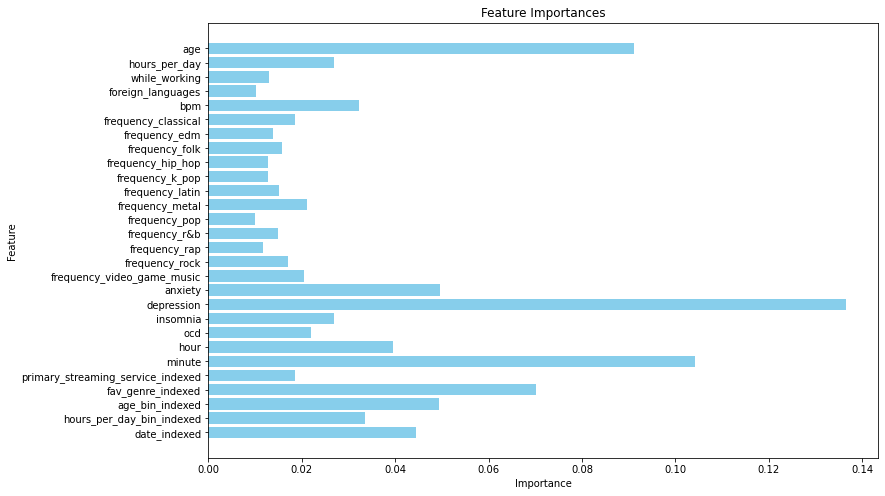

In [7]:
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt

# Define a RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100, maxBins=50)

# Train the model
rf_model = rf.fit(assembled_train_df)

# Get feature importances
importances = rf_model.featureImportances

# Get feature names
feature_names = assembler.getInputCols()

# Combine feature names and importances into a list of tuples, converting importances to float
data = [(feature, float(importance)) for feature, importance in zip(feature_names, importances.toArray())]

# Create a PySpark DataFrame
importance_df = spark.createDataFrame(data, ["Feature", "Importance"])

# Filter features with importance greater than 0.01
important_features_df = importance_df.filter(col("Importance") > 0.01)

# Show the information on the new dataset
important_features_df.show()

# Convert PySpark DataFrame to Pandas DataFrame
importance_pdf = important_features_df.toPandas()

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_pdf["Feature"], importance_pdf["Importance"], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [8]:
# Extracted features into new dataframe
# List of important features to extract
important_features = [
    "age", "hours_per_day", "while_working", "bpm", "frequency_classical",
    "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin",
    "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b",
    "frequency_rock", "frequency_video_game_music", "anxiety", "depression",
    "insomnia", "ocd", "hour", "minute", "primary_streaming_service",
    "fav_genre", "age_bin", "hours_per_day_bin", "date"
]

# Add music_effects to the list of important features
important_features.append("music_effects")

# Extract the important features from the original DataFrame
extracted_df = df.select(*important_features)
# Print schema to understand the structure
extracted_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- hours_per_day: double (nullable = true)
 |-- while_working: integer (nullable = true)
 |-- bpm: double (nullable = true)
 |-- frequency_classical: integer (nullable = true)
 |-- frequency_edm: integer (nullable = true)
 |-- frequency_folk: integer (nullable = true)
 |-- frequency_hip_hop: integer (nullable = true)
 |-- frequency_latin: integer (nullable = true)
 |-- frequency_lofi: integer (nullable = true)
 |-- frequency_metal: integer (nullable = true)
 |-- frequency_pop: integer (nullable = true)
 |-- frequency_r&b: integer (nullable = true)
 |-- frequency_rock: integer (nullable = true)
 |-- frequency_video_game_music: integer (nullable = true)
 |-- anxiety: double (nullable = true)
 |-- depression: double (nullable = true)
 |-- insomnia: double (nullable = true)
 |-- ocd: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- primary_streaming_service: string (nullable = true)
 |-- fav

In [10]:
# Convert the PySpark DataFrame to a Pandas DataFrame
extracted_pd_df = extracted_df.toPandas()

# Calculate the number of null values in each column
null_counts = extracted_pd_df.isnull().sum()

# Print the number of null values in each column
print("Null values in each column:")
print(null_counts)

# Get a concise summary of the DataFrame, including non-null counts and data types
print("\nColumn information:")
extracted_pd_df.info()


Null values in each column:
age                           0
hours_per_day                 0
while_working                 0
bpm                           0
frequency_classical           0
frequency_edm                 0
frequency_folk                0
frequency_hip_hop             0
frequency_latin               0
frequency_lofi                0
frequency_metal               0
frequency_pop                 0
frequency_r&b                 0
frequency_rock                0
frequency_video_game_music    0
anxiety                       0
depression                    0
insomnia                      0
ocd                           0
hour                          0
minute                        0
primary_streaming_service     0
fav_genre                     0
age_bin                       0
hours_per_day_bin             0
date                          0
music_effects                 0
dtype: int64

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Da

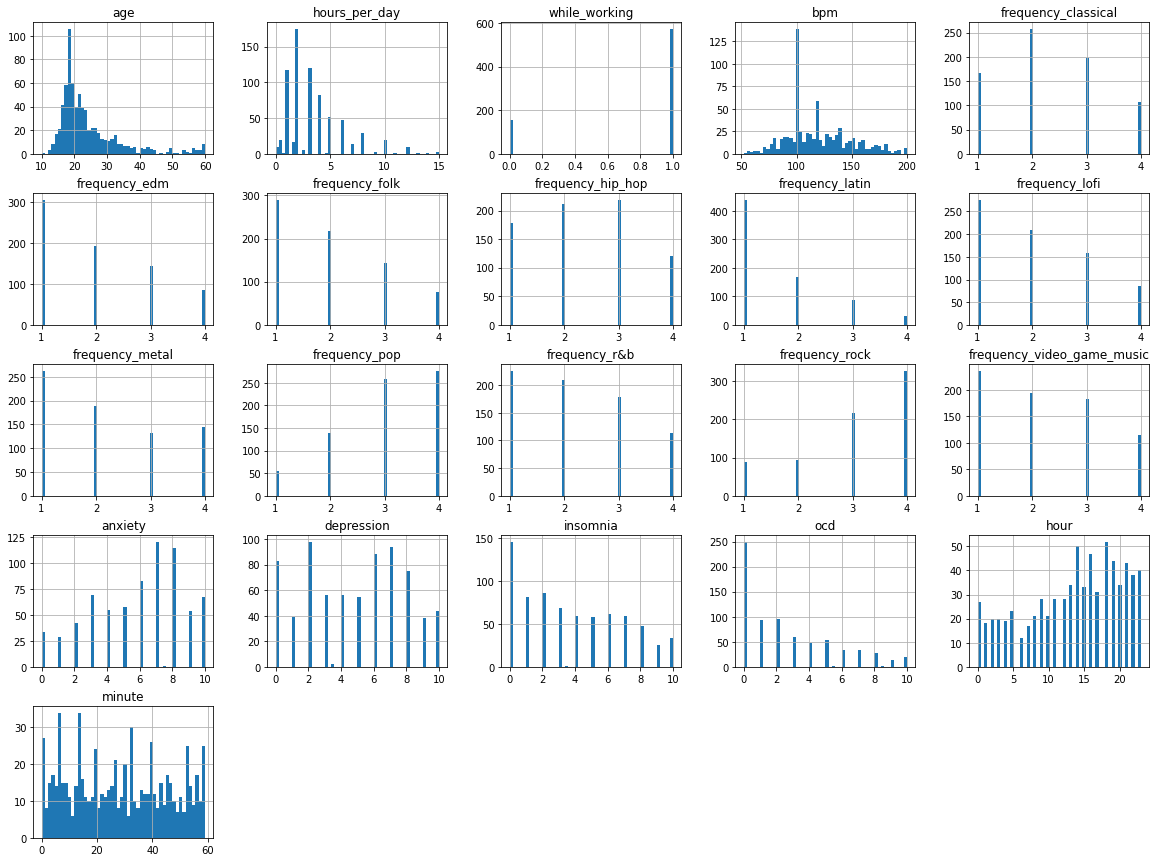

In [37]:
# Visualise distributions of selected features 
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
pandas_df = df.select(important_features).toPandas()

# Plot histograms of the features
pandas_df.hist(figsize=(20, 15), bins=50)
plt.show()


In [11]:
import pandas as pd
from pyspark.sql.functions import col, log, sqrt
from pyspark.sql import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df: DataFrame, columns: list) -> pd.DataFrame:
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# New features df
df = extracted_df
# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df: DataFrame, transformation_func, suffix: str) -> DataFrame:
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log and sqrt transformations
df_log_transformed = transform_columns(df_indexed, lambda c: log(c + 1), 'log')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Extract relevant columns for comparison
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects']]
original_stats = calculate_statistics(df_indexed, numeric_columns)
log_stats = calculate_statistics(df_log_transformed, [f"{col}_log" for col in numeric_columns])
sqrt_stats = calculate_statistics(df_sqrt_transformed, [f"{col}_sqrt" for col in numeric_columns])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nLog-Transformed Data Statistics:")
print(log_stats)
print("\nSquare Root-Transformed Data Statistics:")
print(sqrt_stats)



Original Data Statistics:
                                          skewness                kurtosis
age                           [1.8895857044177138]    [3.6057917718498285]
hours_per_day                  [1.516473713303821]    [2.4660649929599288]
while_working                [-1.4126448280440336]  [-0.00443458980044209]
bpm                           [0.5779459632141106]  [-0.12198299206489782]
frequency_classical          [0.20584697166393687]   [-0.9837042719813489]
frequency_edm                 [0.5950379557774494]   [-0.9230320719250535]
frequency_folk                [0.5988432284183117]   [-0.8154313530521917]
frequency_hip_hop             [0.0876266545078173]   [-1.1425673133392718]
frequency_latin               [1.2665004966342674]    [0.5939484932438441]
frequency_lofi                [0.4968070382788795]   [-0.9731223155493645]
frequency_metal               [0.3831478025447569]   [-1.2720957706799887]
frequency_pop                [-0.6336414089562802]   [-0.5574416487122815]

Original Data Statistics:
                                          skewness                kurtosis
age                           [1.8895857044177138]    [3.6057917718498285]
hours_per_day                  [1.516473713303821]    [2.4660649929599288]
while_working                [-1.4126448280440336]  [-0.00443458980044209]
bpm                           [0.5779459632141106]  [-0.12198299206489782]
frequency_classical          [0.20584697166393687]   [-0.9837042719813489]
frequency_edm                 [0.5950379557774494]   [-0.9230320719250535]
frequency_folk                [0.5988432284183117]   [-0.8154313530521917]
frequency_hip_hop             [0.0876266545078173]   [-1.1425673133392718]
frequency_latin               [1.2665004966342674]    [0.5939484932438441]
frequency_lofi                [0.4968070382788795]   [-0.9731223155493645]
frequency_metal               [0.3831478025447569]   [-1.2720957706799887]
frequency_pop                [-0.6336414089562802]   [-0.5574416487122815]

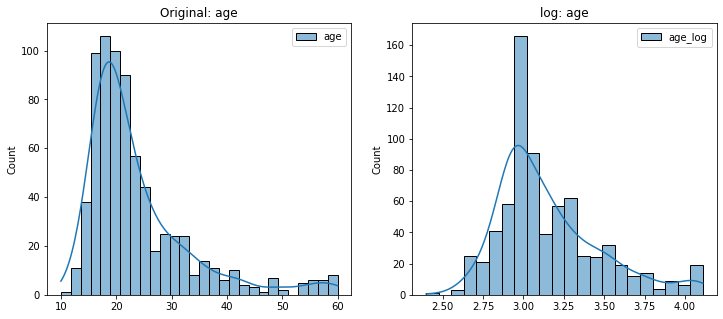

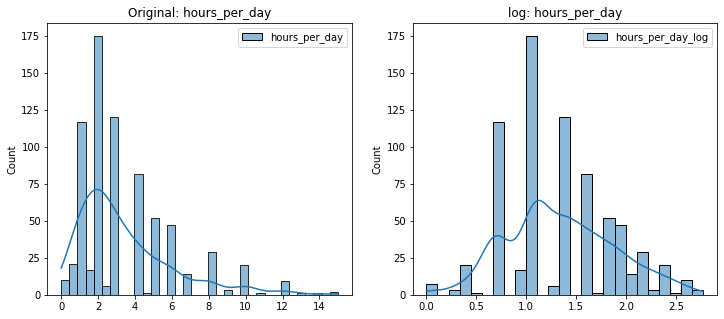

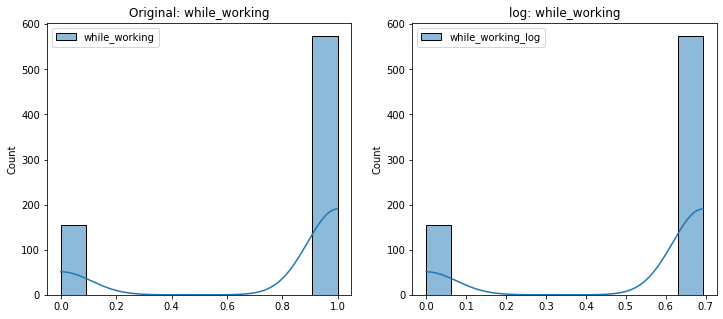

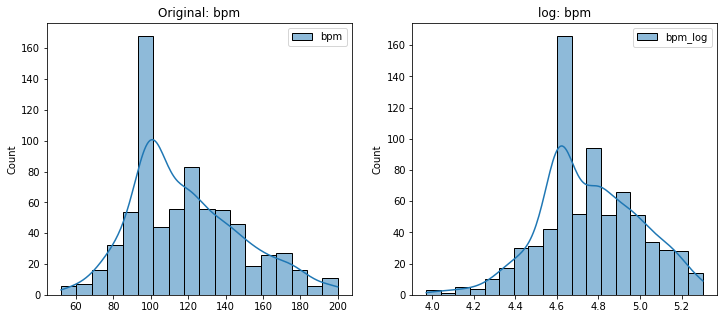

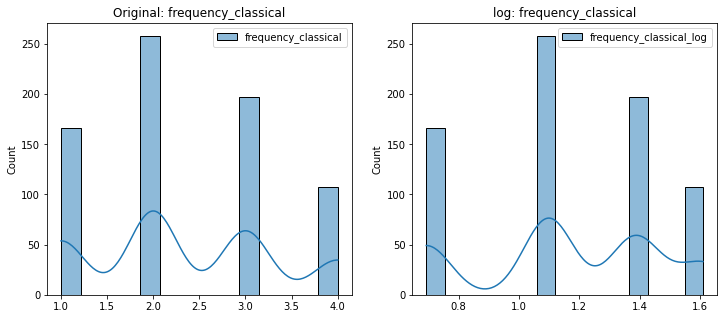

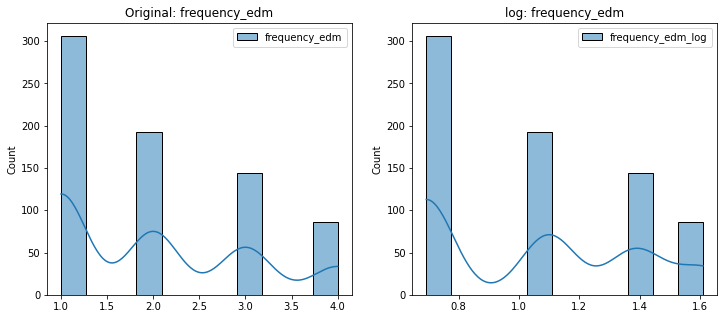

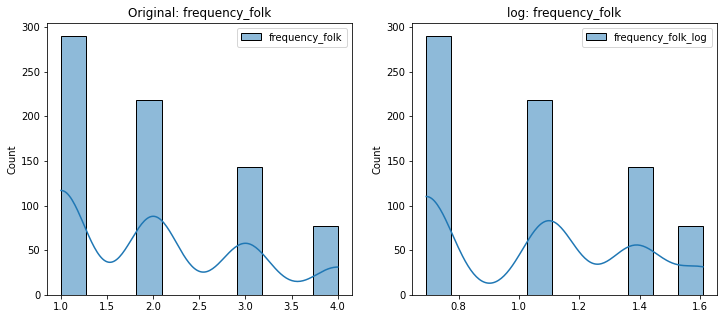

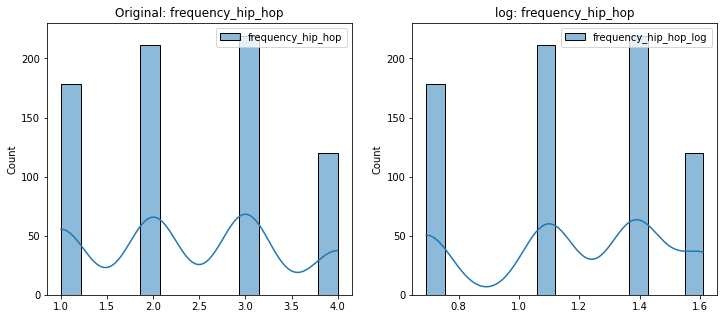

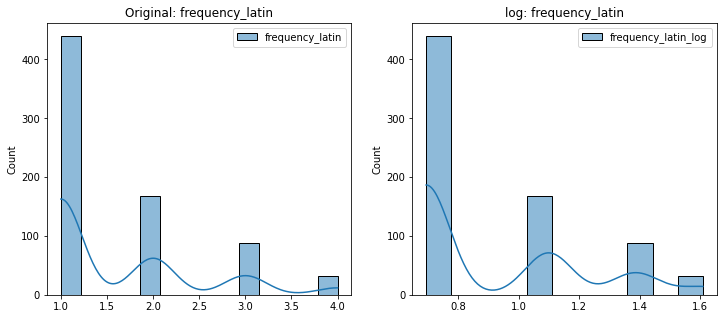

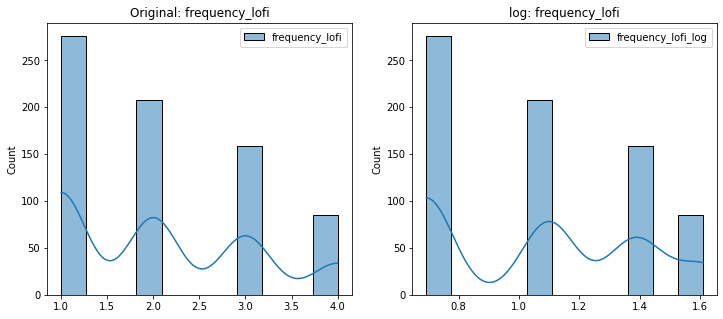

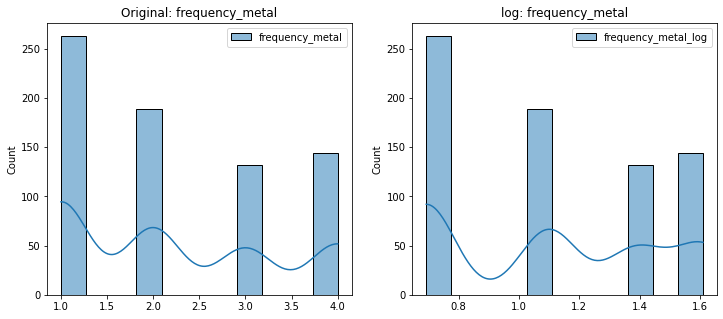

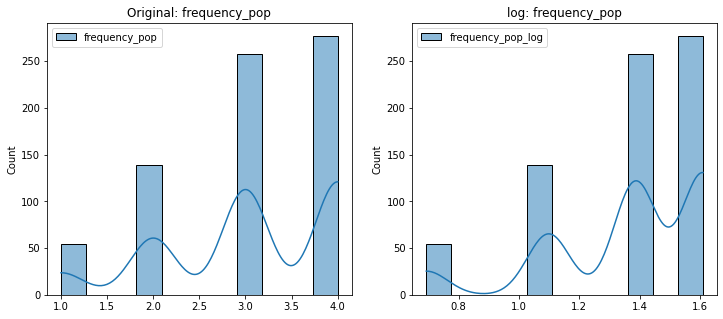

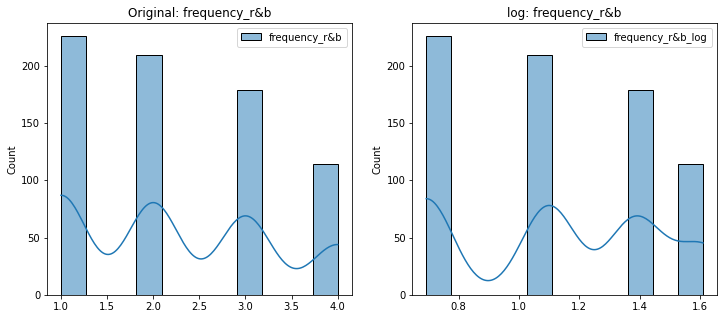

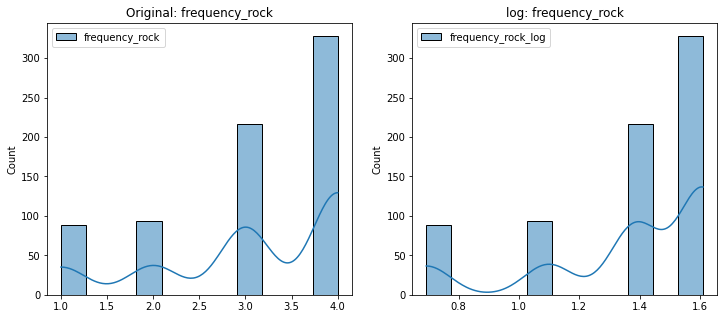

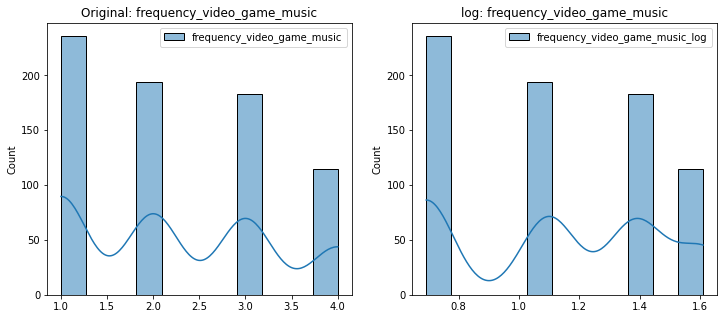

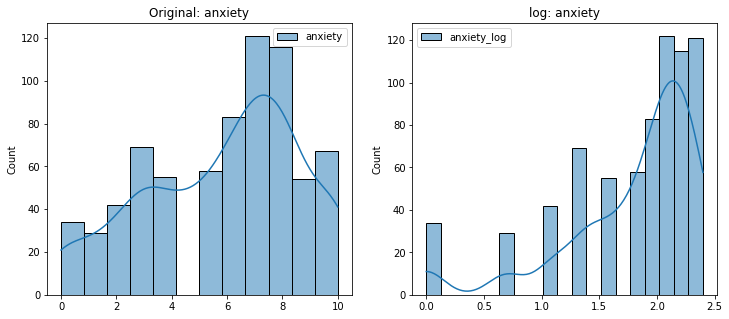

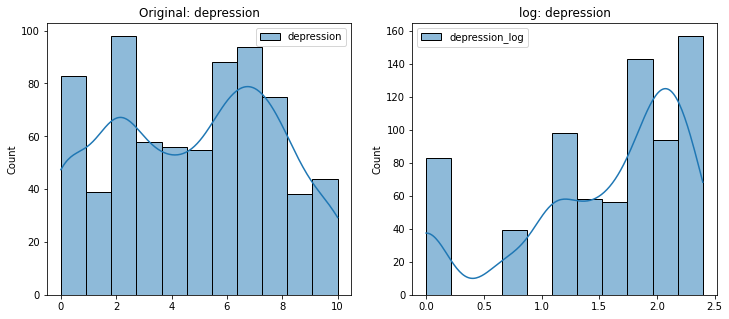

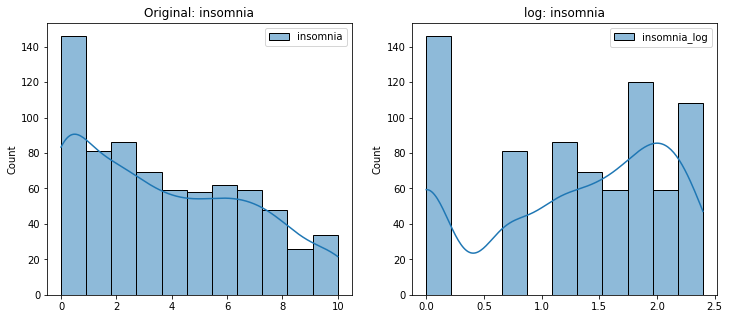

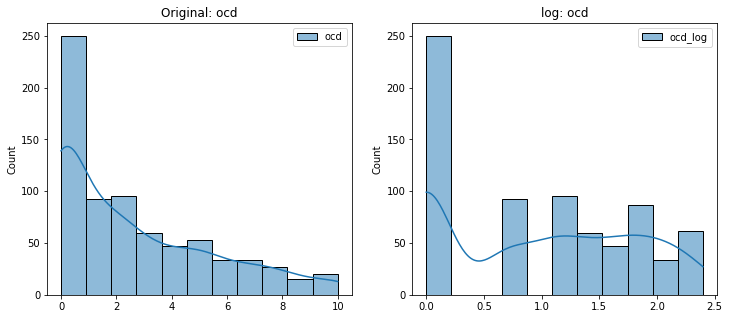

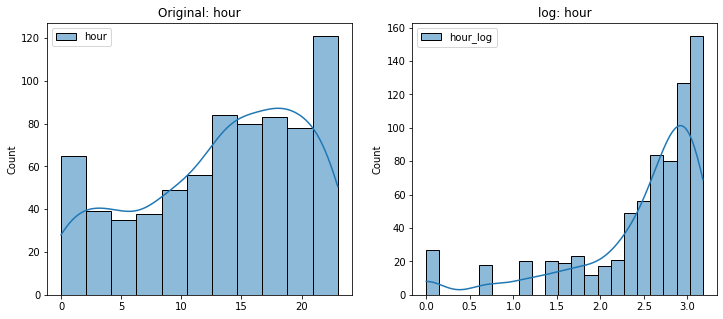

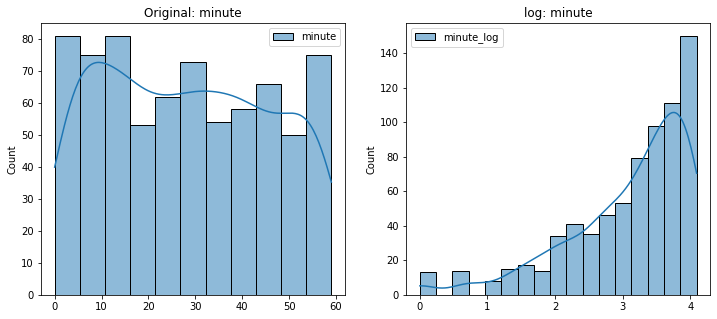

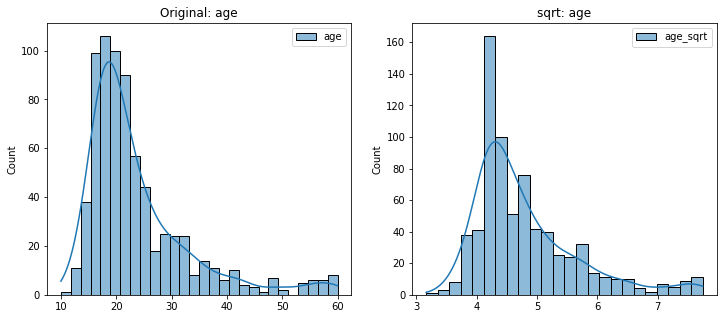

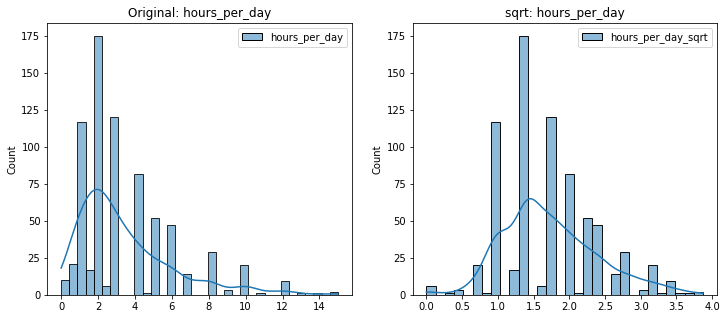

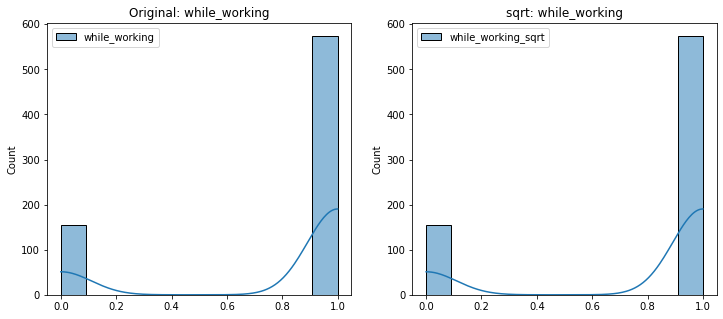

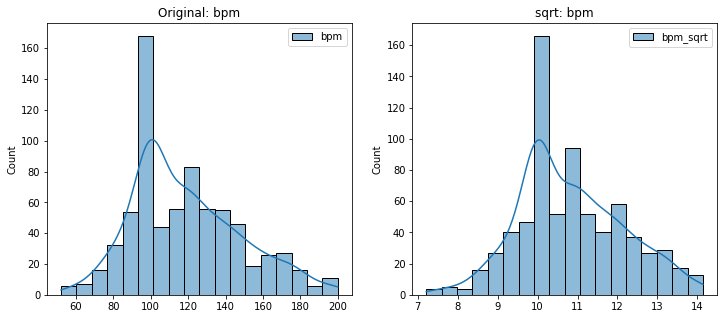

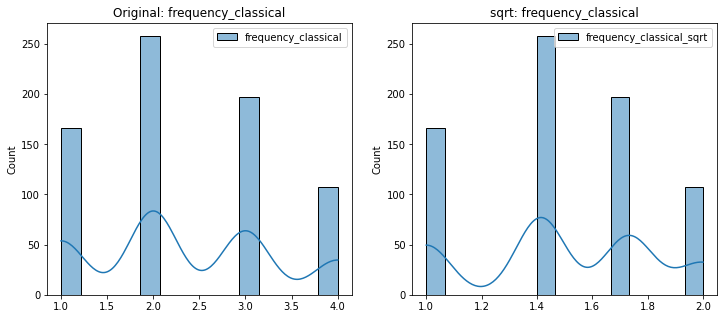

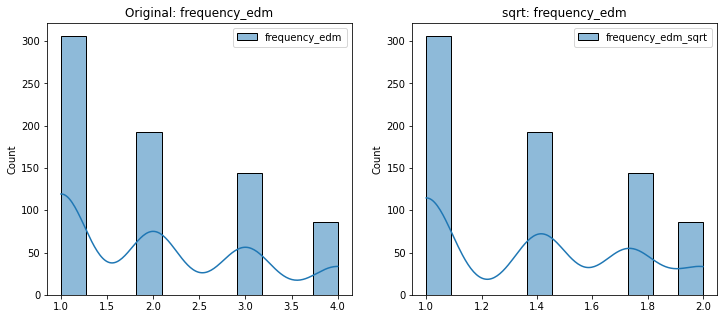

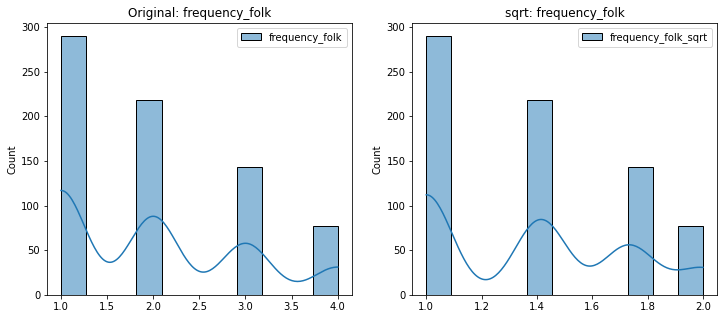

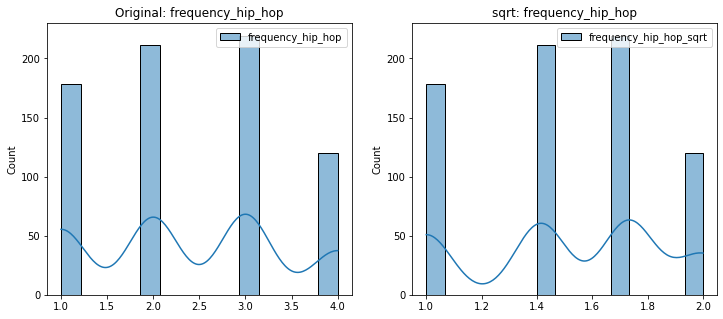

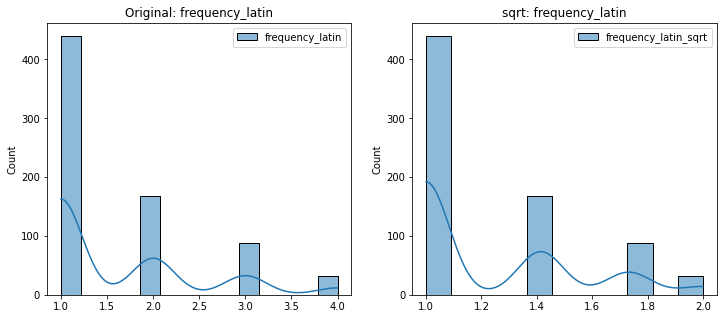

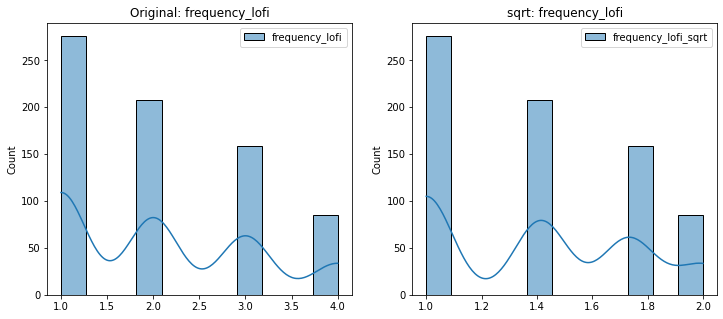

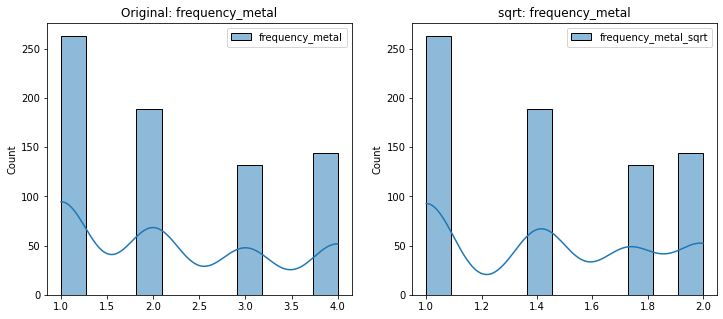

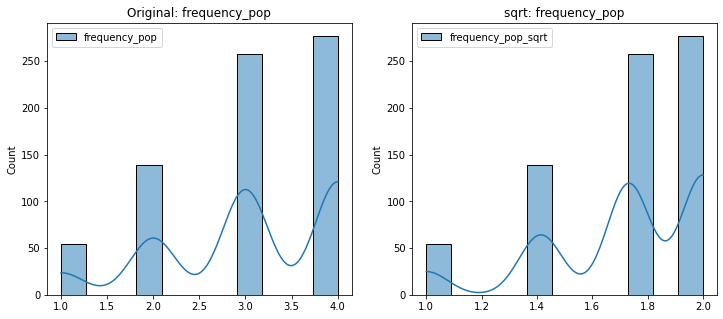

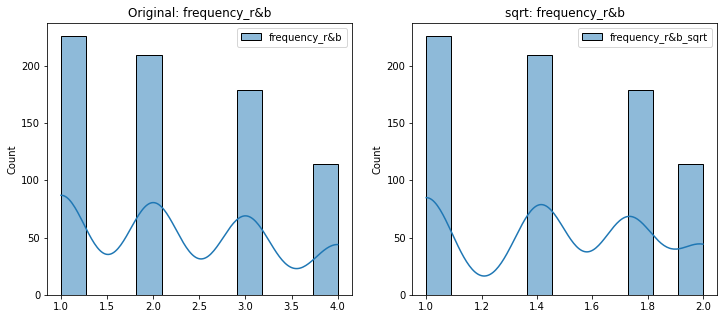

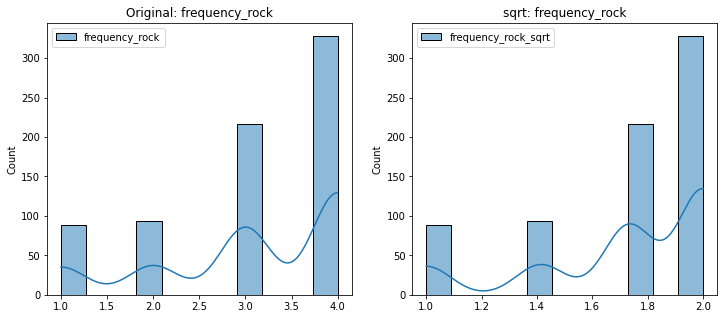

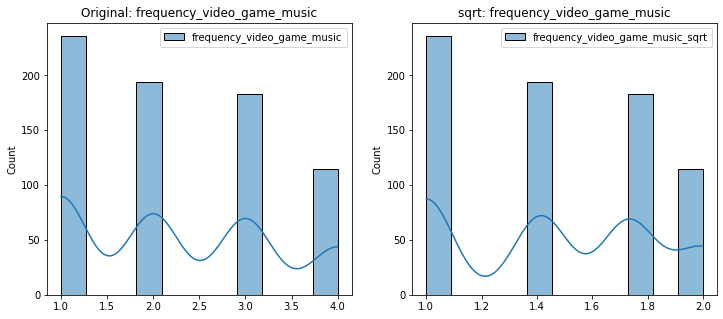

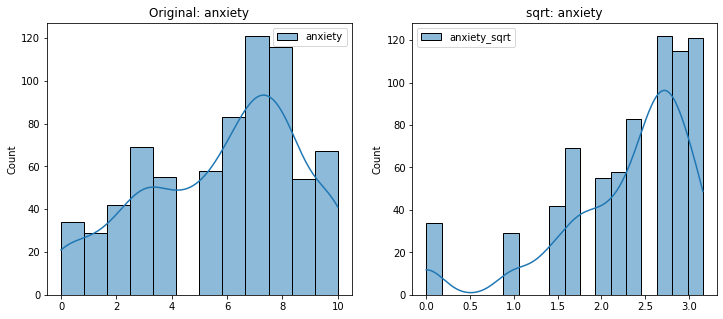

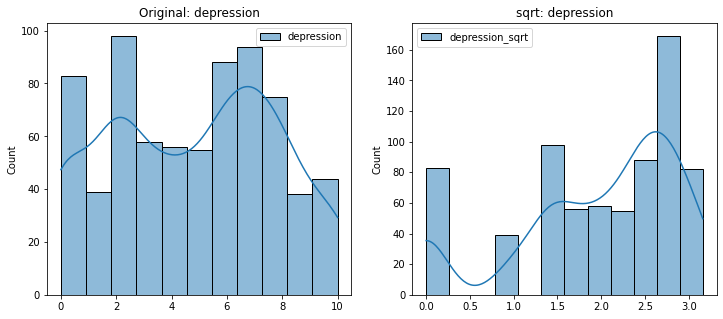

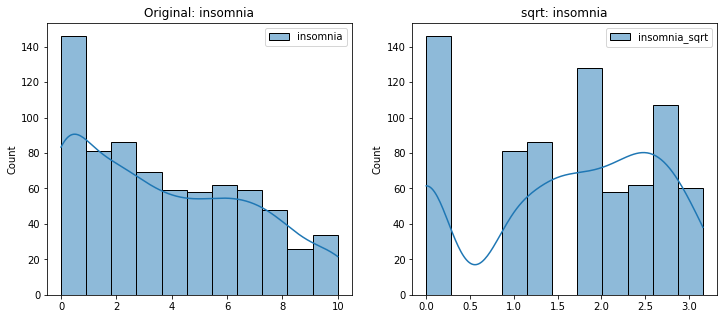

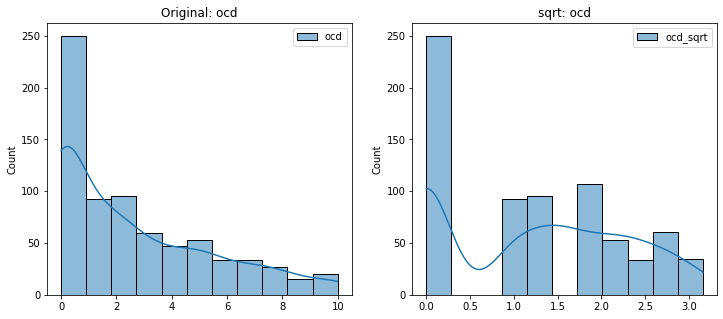

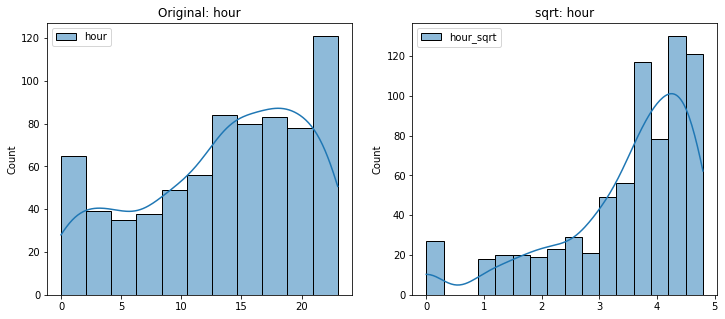

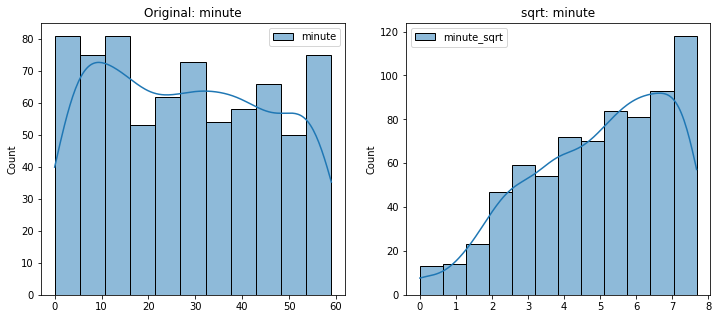

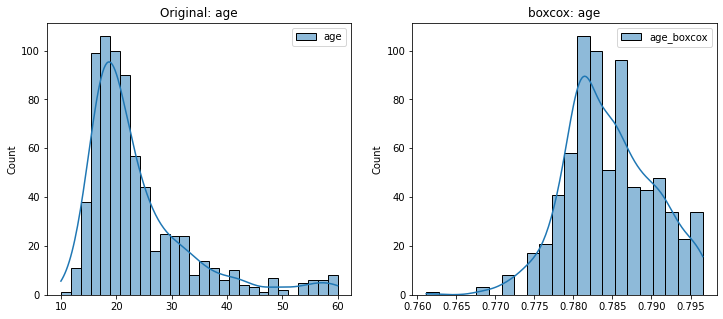

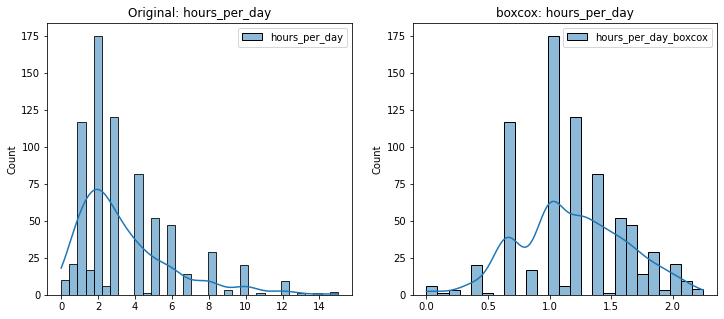

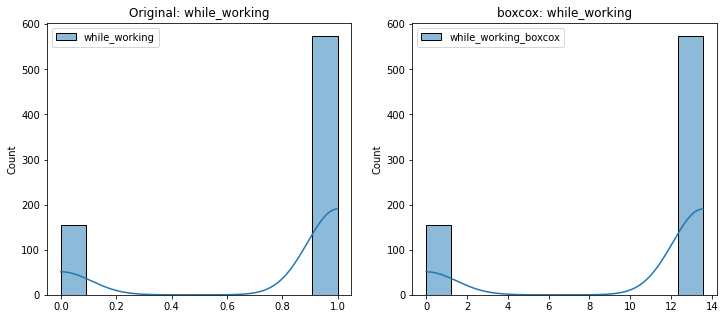

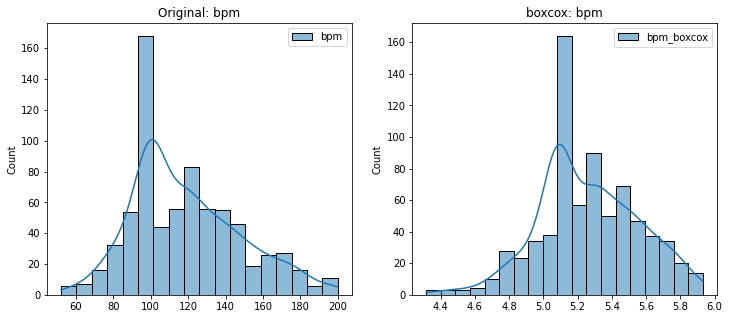

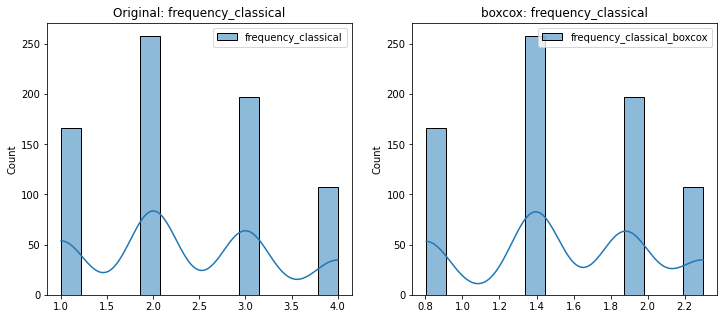

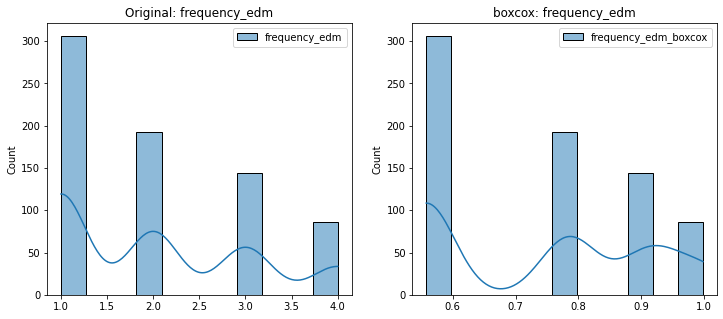

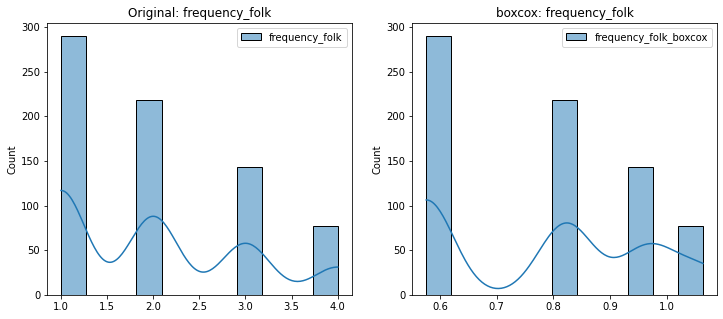

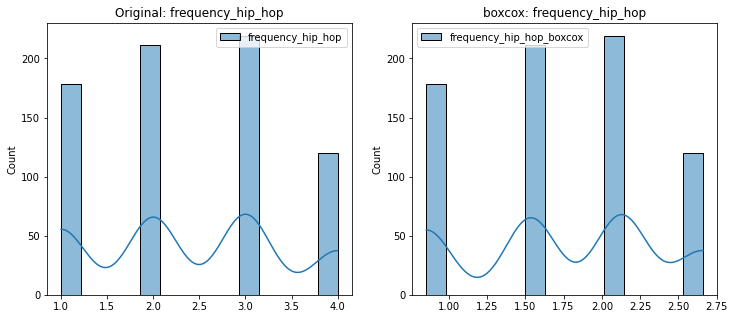

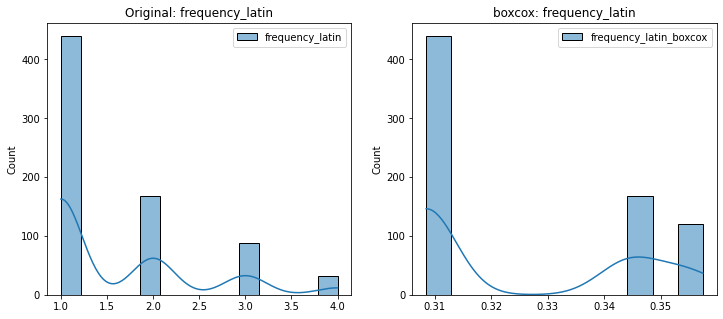

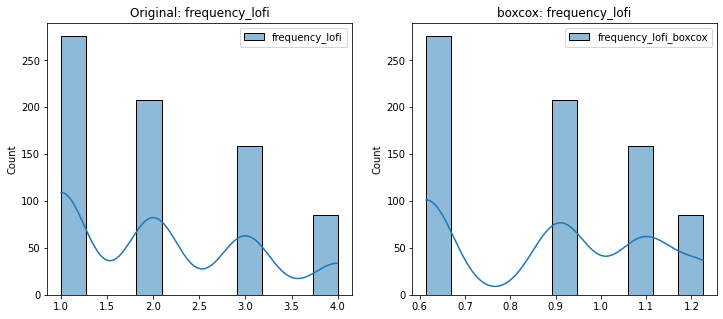

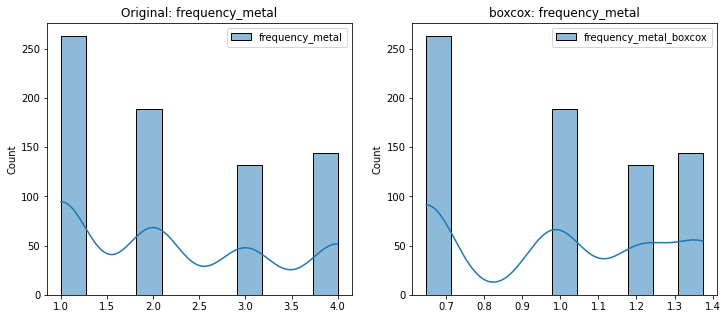

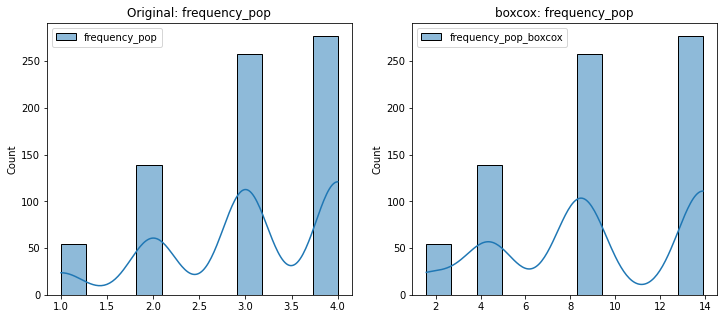

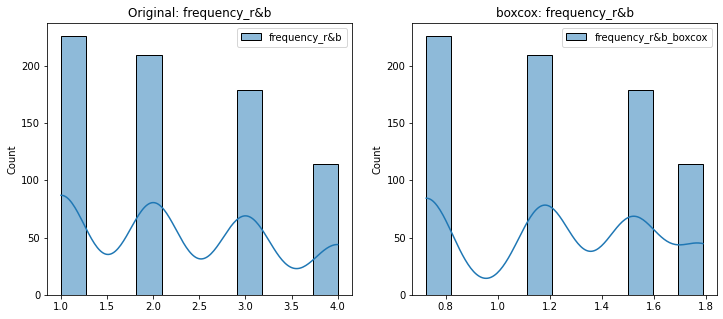

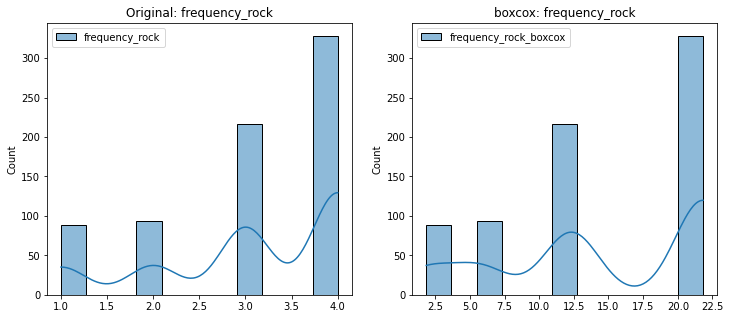

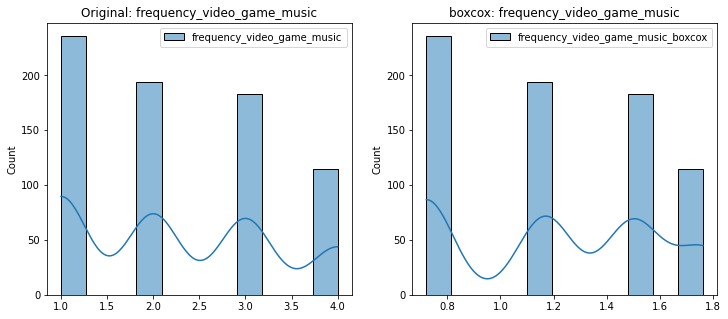

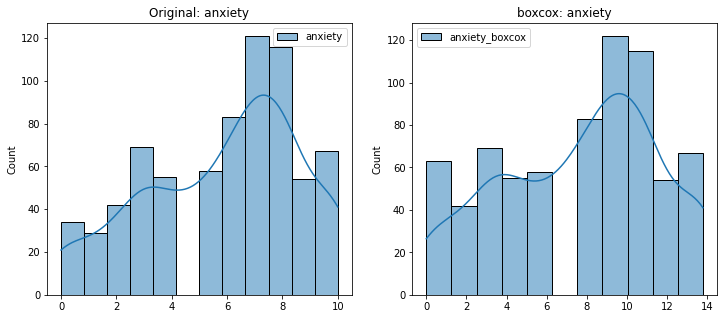

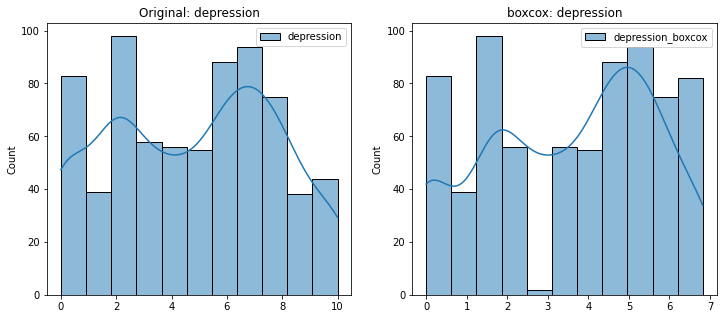

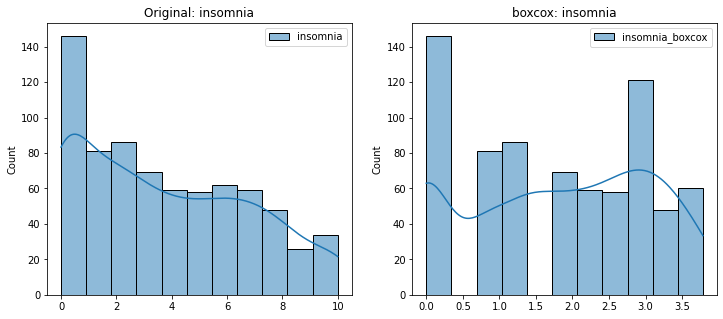

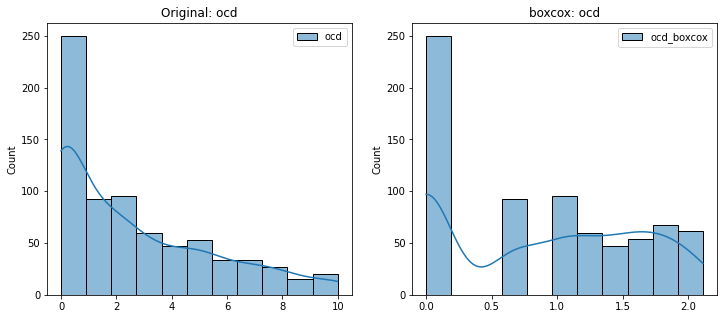

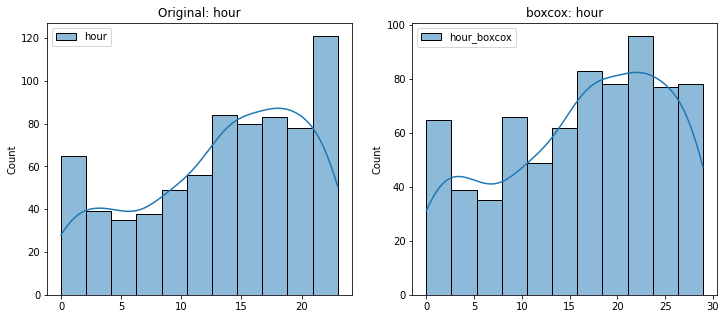

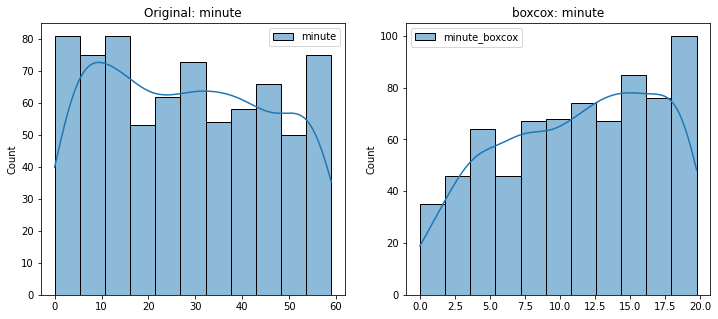

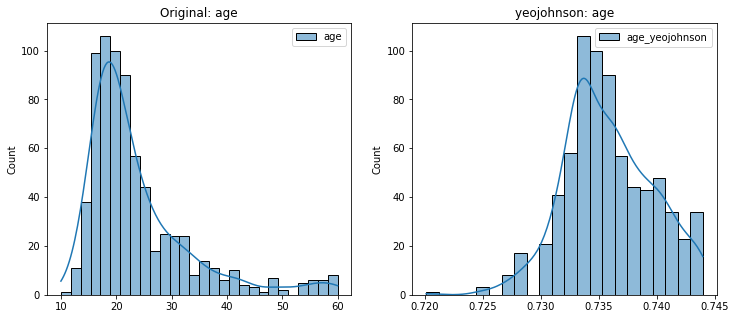

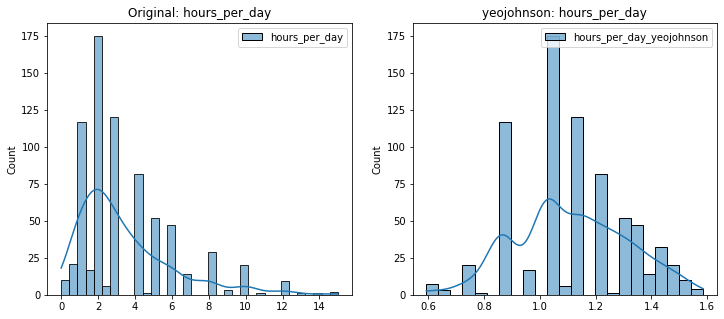

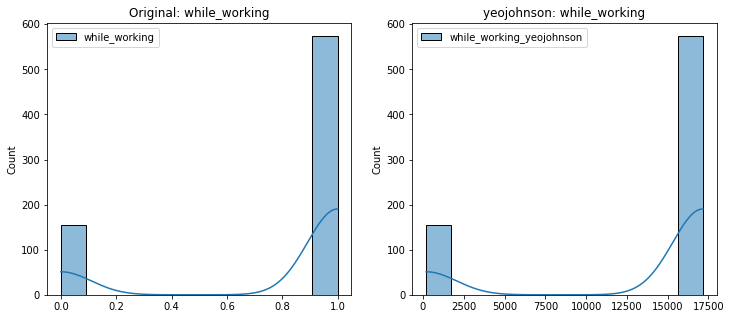

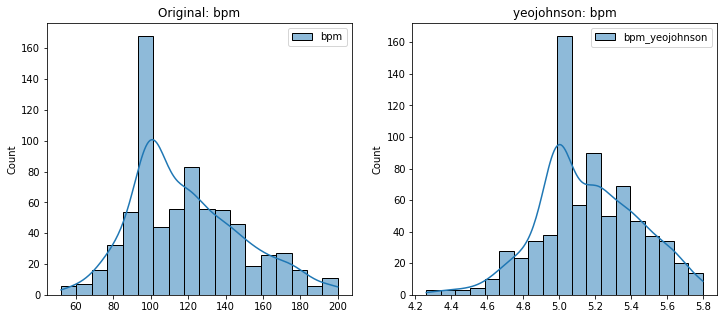

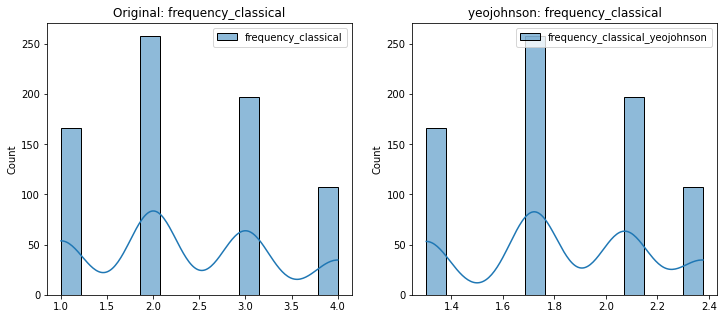

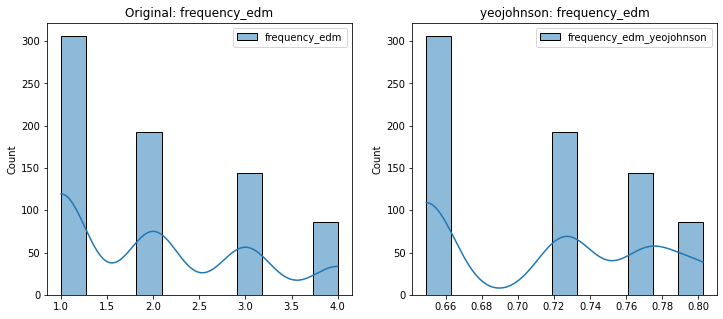

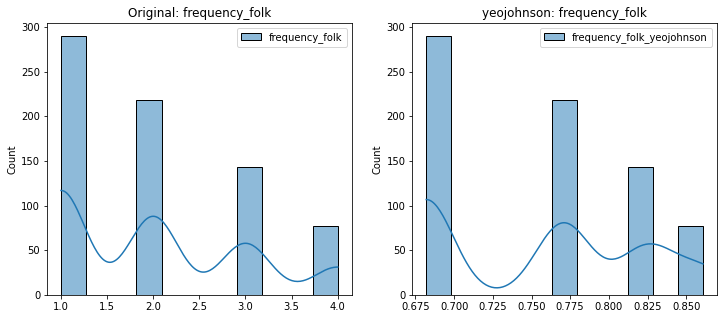

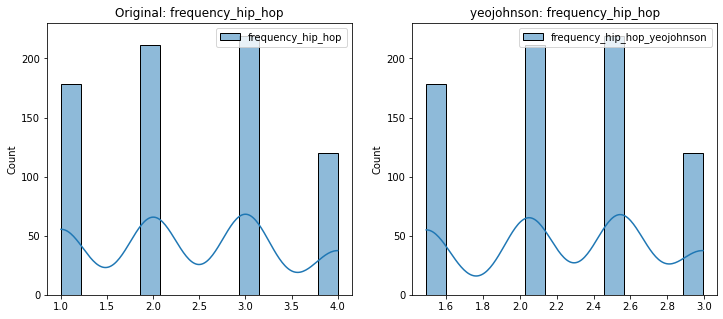

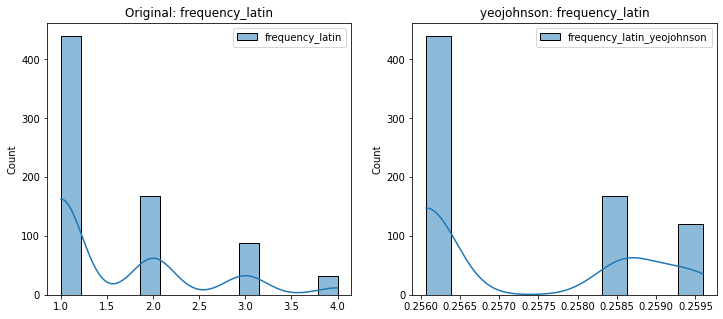

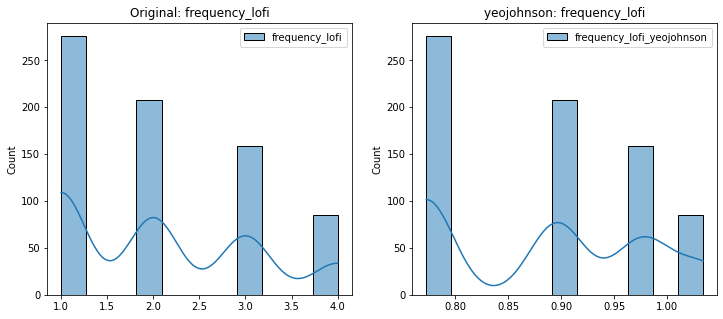

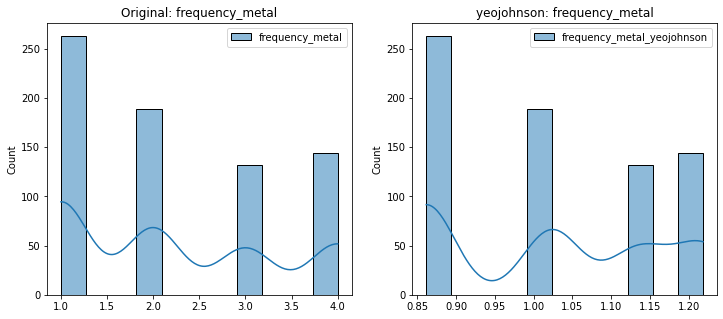

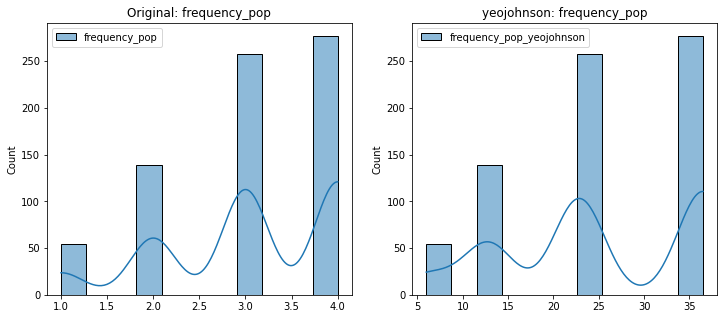

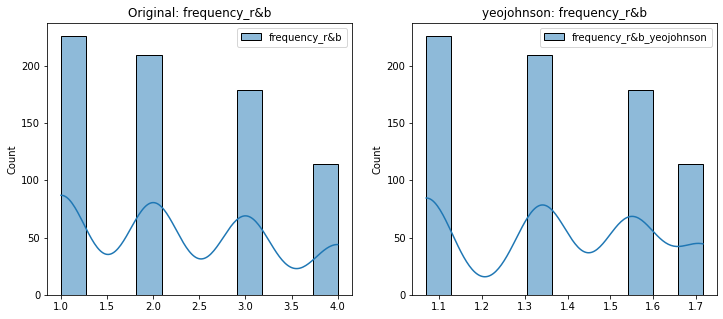

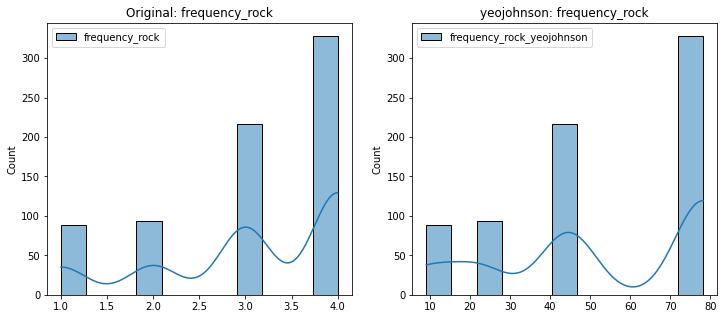

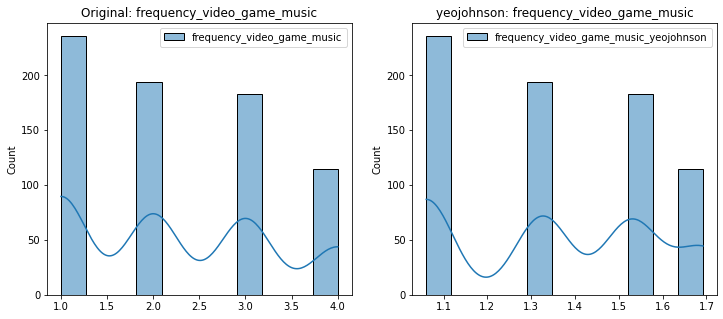

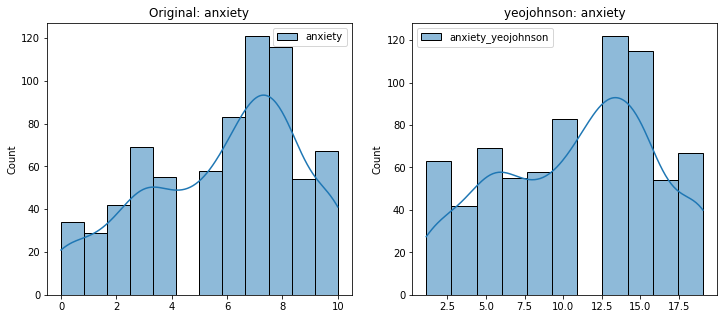

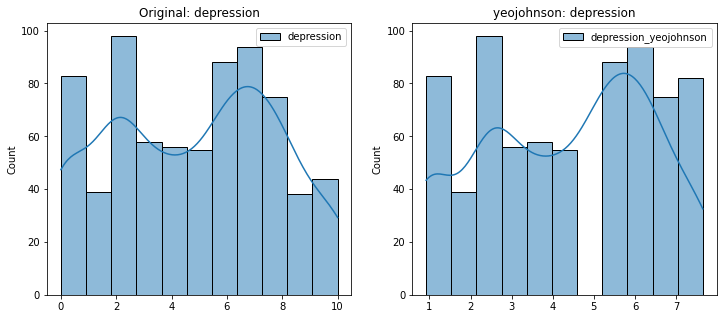

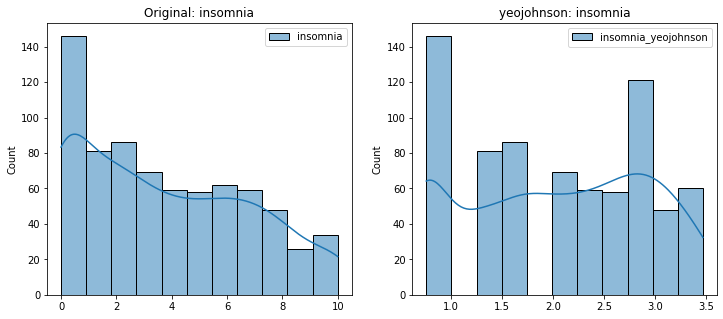

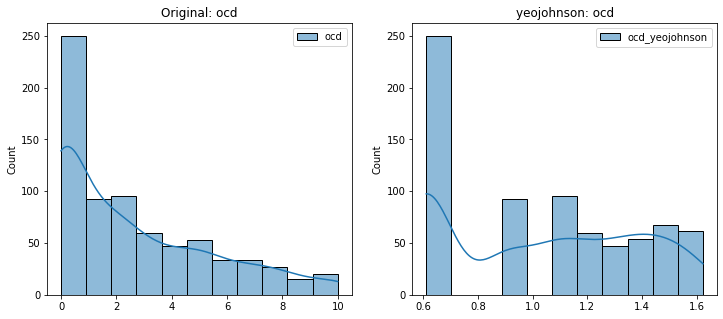

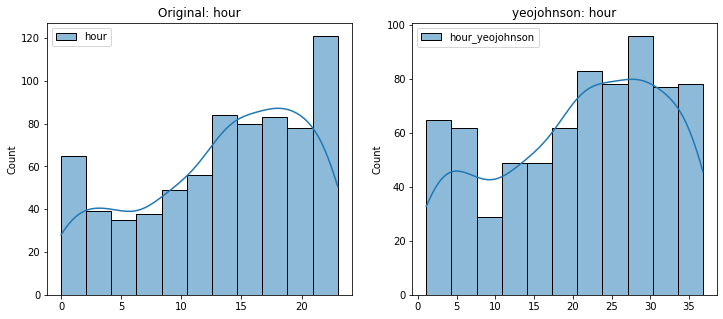

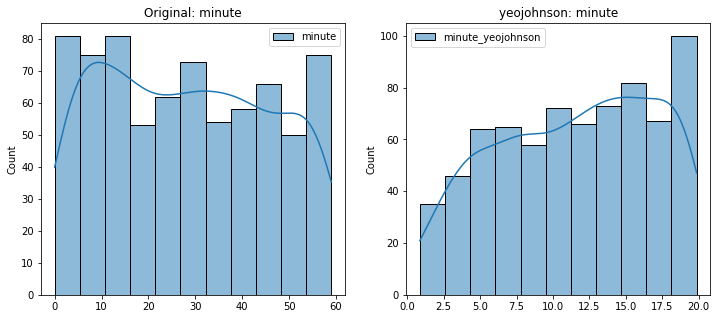

In [26]:
import pandas as pd
from pyspark.sql.functions import col, log, sqrt
from pyspark.sql import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, boxcox, yeojohnson
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df: DataFrame, columns: list) -> pd.DataFrame:
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# New features df
df = extracted_df
# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df: DataFrame, transformation_func, suffix: str) -> DataFrame:
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log and sqrt transformations
df_log_transformed = transform_columns(df_indexed, lambda c: log(c + 1), 'log')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Apply Box-Cox and Yeo-Johnson transformations
def apply_statistical_transformation(df: DataFrame, columns: list, method='boxcox') -> pd.DataFrame:
    pandas_df = df.select(columns).toPandas()
    transformed_data = pd.DataFrame()
    for column in columns:
        if method == 'boxcox':
            transformed_data[f"{column}_boxcox"] = boxcox(pandas_df[column] + 1)[0]  # boxcox requires positive values
        elif method == 'yeojohnson':
            transformed_data[f"{column}_yeojohnson"] = yeojohnson(pandas_df[column] + 1)[0]
    return spark.createDataFrame(transformed_data)
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects']]
boxcox_transformed_df = apply_statistical_transformation(df_indexed, numeric_columns, method='boxcox')
yeojohnson_transformed_df = apply_statistical_transformation(df_indexed, numeric_columns, method='yeojohnson')

# Calculate statistics for Box-Cox and Yeo-Johnson transformations
boxcox_stats = calculate_statistics(boxcox_transformed_df, [f"{col}_boxcox" for col in numeric_columns])
yeojohnson_stats = calculate_statistics(yeojohnson_transformed_df, [f"{col}_yeojohnson" for col in numeric_columns])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nLog-Transformed Data Statistics:")
print(log_stats)
print("\nSquare Root-Transformed Data Statistics:")
print(sqrt_stats)
print("\nBox-Cox Transformed Data Statistics:")
print(boxcox_stats)
print("\nYeo-Johnson Transformed Data Statistics:")
print(yeojohnson_stats)

# Function to visualize distributions before and after transformations
def plot_distributions(original_df, transformed_df, transformation_name):
    for column in numeric_columns:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(original_df.select(col(column)).toPandas().dropna(), kde=True)
        plt.title(f'Original: {column}')
        plt.subplot(1, 2, 2)
        sns.histplot(transformed_df.select(col(f"{column}_{transformation_name}")).toPandas().dropna(), kde=True)
        plt.title(f'{transformation_name}: {column}')
        plt.show()

# Plot distributions
plot_distributions(df_indexed, df_log_transformed, 'log')
plot_distributions(df_indexed, df_sqrt_transformed, 'sqrt')
plot_distributions(df_indexed, boxcox_transformed_df, 'boxcox')
plot_distributions(df_indexed, yeojohnson_transformed_df, 'yeojohnson')


In [9]:
#4.2 transformation
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson, boxcox, skew, kurtosis
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df, columns):
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# Function to apply Yeo-Johnson transformation
def apply_yeojohnson(df, columns):
    numeric_df = df.select(columns + ['music_effects']).toPandas()  # Convert to Pandas DataFrame
    transformed_data = pd.DataFrame()
    transformed_data['music_effects'] = numeric_df['music_effects']
    for column in columns:
        transformed_data[f"{column}_yeojohnson"] = yeojohnson(numeric_df[column].astype(float))[0]
    return spark.createDataFrame(transformed_data)

# Function to apply Box-Cox transformation
def apply_boxcox(df, columns):
    pandas_df = df.select(columns + ['music_effects']).toPandas()
    transformed_data = pd.DataFrame()
    transformed_data['music_effects'] = pandas_df['music_effects']
    for column in columns:
        transformed_data[f"{column}_boxcox"], _ = boxcox(pandas_df[column] + 1)  # Adding 1 to ensure all values are positive
    return spark.createDataFrame(transformed_data)

# Ensure numeric columns are of DoubleType for transformations
df = extracted_df
df = df.withColumn("age", col("age").cast(DoubleType()))\
       .withColumn("hours_per_day", col("hours_per_day").cast(DoubleType()))\
       .withColumn("bpm", col("bpm").cast(DoubleType()))\
       .withColumn("frequency_classical", col("frequency_classical").cast(DoubleType()))\
       .withColumn("frequency_edm", col("frequency_edm").cast(DoubleType()))\
       .withColumn("frequency_folk", col("frequency_folk").cast(DoubleType()))\
       .withColumn("frequency_hip_hop", col("frequency_hip_hop").cast(DoubleType()))\
       .withColumn("frequency_latin", col("frequency_latin").cast(DoubleType()))\
       .withColumn("frequency_lofi", col("frequency_lofi").cast(DoubleType()))\
       .withColumn("frequency_metal", col("frequency_metal").cast(DoubleType()))\
       .withColumn("frequency_pop", col("frequency_pop").cast(DoubleType()))\
       .withColumn("frequency_r&b", col("frequency_r&b").cast(DoubleType()))\
       .withColumn("frequency_rock", col("frequency_rock").cast(DoubleType()))\
       .withColumn("frequency_video_game_music", col("frequency_video_game_music").cast(DoubleType()))\
       .withColumn("anxiety", col("anxiety").cast(IntegerType()))\
       .withColumn("depression", col("depression").cast(IntegerType()))\
       .withColumn("insomnia", col("insomnia").cast(IntegerType()))\
       .withColumn("ocd", col("ocd").cast(IntegerType()))\
       .withColumn("music_effects", col("music_effects").cast(IntegerType()))

# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Apply Yeo-Johnson transformation to the relevant numeric columns
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects', 'hours_per_day', 'bpm']]
yeojohnson_transformed_df = apply_yeojohnson(df_indexed, numeric_columns)

# Apply Box-Cox transformation to hours_per_day and bpm
boxcox_transformed_df = apply_boxcox(df_indexed, ['hours_per_day', 'bpm'])

# Calculate statistics
original_stats = calculate_statistics(df_indexed, numeric_columns + ['hours_per_day', 'bpm'])
yeojohnson_stats = calculate_statistics(yeojohnson_transformed_df, [f"{col}_yeojohnson" for col in numeric_columns])
boxcox_stats = calculate_statistics(boxcox_transformed_df, ['hours_per_day_boxcox', 'bpm_boxcox'])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nYeo-Johnson Transformed Data Statistics:")
print(yeojohnson_stats)
print("\nBox-Cox Transformed Data Statistics:")
print(boxcox_stats)

# Concatenate statistics dataframes
combined_stats = pd.concat([original_stats, yeojohnson_stats, boxcox_stats], axis=1)

# Print combined statistics
print("Combined Statistics:")
print(combined_stats)



Original Data Statistics:
                                           skewness                kurtosis
age                            [1.8895857044177138]    [3.6057917718498285]
while_working                 [-1.4126448280440336]  [-0.00443458980044209]
frequency_classical           [0.20584697166393687]   [-0.9837042719813489]
frequency_edm                  [0.5950379557774494]   [-0.9230320719250535]
frequency_folk                 [0.5988432284183117]   [-0.8154313530521917]
frequency_hip_hop              [0.0876266545078173]   [-1.1425673133392718]
frequency_latin                [1.2665004966342674]    [0.5939484932438441]
frequency_lofi                 [0.4968070382788795]   [-0.9731223155493645]
frequency_metal                [0.3831478025447569]   [-1.2720957706799887]
frequency_pop                 [-0.6336414089562802]   [-0.5574416487122815]
frequency_r&b                 [0.28379711011024733]    [-1.163480028265298]
frequency_rock                [-0.8235623678229196]   [-0.5425

In [10]:
# Concatenate statistics dataframes
combined_stats = pd.concat([original_stats, yeojohnson_stats, boxcox_stats], axis=1)

# Join the transformed dataframes with the original dataframe
combined_transformed_df = extracted_df

# Rename columns to remove suffixes
for column in numeric_columns:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))
for column in ['hours_per_day', 'bpm']:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))

# Include string columns
for column in string_cols:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))

# Show the combined transformed dataframe with the selected columns
#combined_transformed_df.show()

# Print the schema of the combined transformed dataframe
combined_transformed_df.printSchema()


root
 |-- age: integer (nullable = true)
 |-- hours_per_day: double (nullable = true)
 |-- while_working: integer (nullable = true)
 |-- bpm: double (nullable = true)
 |-- frequency_classical: integer (nullable = true)
 |-- frequency_edm: integer (nullable = true)
 |-- frequency_folk: integer (nullable = true)
 |-- frequency_hip_hop: integer (nullable = true)
 |-- frequency_latin: integer (nullable = true)
 |-- frequency_lofi: integer (nullable = true)
 |-- frequency_metal: integer (nullable = true)
 |-- frequency_pop: integer (nullable = true)
 |-- frequency_r&b: integer (nullable = true)
 |-- frequency_rock: integer (nullable = true)
 |-- frequency_video_game_music: integer (nullable = true)
 |-- anxiety: double (nullable = true)
 |-- depression: double (nullable = true)
 |-- insomnia: double (nullable = true)
 |-- ocd: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- primary_streaming_service: string (nullable = true)
 |-- fav

# 6 

In [11]:
#Random forest base
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

# Index string columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Assemble features into a vector
feature_columns = [col for col in combined_transformed_df.columns if col not in string_cols + ['music_effects']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
rf_model = pipeline.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Random Forest - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

Random Forest - Accuracy: 0.7521367521367521, Precision: 0.5657096939148221, Recall: 0.7521367521367521


In [16]:
# Random forest with hyper parameters 80/20 split
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define string columns and feature columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical",
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin",
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b",
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression",
                   "insomnia", "ocd", "hour", "minute"]

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200])
             .addGrid(rf.maxDepth, [5, 10, 20])
             .addGrid(rf.minInstancesPerNode, [1, 5, 10])
             .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2'])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")

# Define the cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel

# Print the best parameters
print(f"Best numTrees: {best_model.stages[-1].getOrDefault('numTrees')}")
print(f"Best maxDepth: {best_model.stages[-1].getOrDefault('maxDepth')}")
print(f"Best minInstancesPerNode: {best_model.stages[-1].getOrDefault('minInstancesPerNode')}")
print(f"Best featureSubsetStrategy: {best_model.stages[-1].getOrDefault('featureSubsetStrategy')}")

# Evaluate the best model on the test set
test_predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")


24/05/25 09:37:26 WARN DAGScheduler: Broadcasting large task binary with size 1041.4 KiB
24/05/25 09:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1041.4 KiB
24/05/25 09:37:46 WARN DAGScheduler: Broadcasting large task binary with size 1041.4 KiB
24/05/25 09:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1179.2 KiB
24/05/25 09:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1300.4 KiB
24/05/25 09:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1399.8 KiB
24/05/25 09:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1483.7 KiB
24/05/25 09:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1350.0 KiB
24/05/25 09:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1217.6 KiB
24/05/25 09:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1093.7 KiB
24/05/25 09:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1190.8 KiB
24/05/25 09:37:50 WAR

24/05/25 09:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1360.1 KiB
24/05/25 09:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1522.9 KiB
24/05/25 09:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1606.0 KiB
24/05/25 09:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1576.5 KiB
24/05/25 09:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
24/05/25 09:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1163.3 KiB
24/05/25 09:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1360.1 KiB
24/05/25 09:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1522.9 KiB
24/05/25 09:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1606.0 KiB
24/05/25 09:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1576.5 KiB
24/05/25 09:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
24/05/25 09:39:08 WAR

24/05/25 09:40:22 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/05/25 09:40:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/25 09:40:23 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/05/25 09:40:23 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/05/25 09:40:23 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/05/25 09:40:24 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/25 09:40:24 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/25 09:40:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/25 09:40:25 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 09:40:25 WARN DAGScheduler: Broadcasting large task binary with size 2026.1 KiB
24/05/25 09:40:25 WARN DAGScheduler: Broadcasting large task binary with size 1729.1 KiB
24/05/25 09:40:25 WARN DAGScheduler: Broadcastin

24/05/25 09:41:31 WARN DAGScheduler: Broadcasting large task binary with size 1294.7 KiB
24/05/25 09:41:31 WARN DAGScheduler: Broadcasting large task binary with size 1174.7 KiB
24/05/25 09:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
24/05/25 09:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1144.2 KiB
24/05/25 09:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1103.7 KiB
24/05/25 09:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1231.5 KiB
24/05/25 09:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1337.5 KiB
24/05/25 09:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1426.8 KiB
24/05/25 09:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1415.8 KiB
24/05/25 09:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1373.9 KiB
24/05/25 09:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1122.6 KiB
24/05/25 09:41:35 WAR

24/05/25 09:42:54 WARN DAGScheduler: Broadcasting large task binary with size 1073.0 KiB
24/05/25 09:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1024.8 KiB
24/05/25 09:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1282.6 KiB
24/05/25 09:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1801.2 KiB
24/05/25 09:43:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 09:43:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/05/25 09:43:10 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/25 09:43:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/25 09:43:12 WARN DAGScheduler: Broadcasting large task binary with size 1282.6 KiB
24/05/25 09:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1801.2 KiB
24/05/25 09:43:13 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 09:43:14 WARN DAGScheduler:

24/05/25 09:43:59 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/05/25 09:43:59 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/05/25 09:44:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/25 09:44:00 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/25 09:44:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 09:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1760.1 KiB
24/05/25 09:44:01 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/25 09:44:03 WARN DAGScheduler: Broadcasting large task binary with size 1337.2 KiB
24/05/25 09:44:03 WARN DAGScheduler: Broadcasting large task binary with size 1789.1 KiB
24/05/25 09:44:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 09:44:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 09:44:04 WARN DAGScheduler: Broadcas

24/05/25 09:45:29 WARN DAGScheduler: Broadcasting large task binary with size 1746.1 KiB
24/05/25 09:45:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/05/25 09:45:30 WARN DAGScheduler: Broadcasting large task binary with size 1588.9 KiB
24/05/25 09:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1233.4 KiB
24/05/25 09:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1541.6 KiB
24/05/25 09:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1859.3 KiB
24/05/25 09:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1437.6 KiB
24/05/25 09:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1011.0 KiB
24/05/25 09:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1229.6 KiB
24/05/25 09:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1412.9 KiB
24/05/25 09:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1543.5 KiB
24/05/25 09:45:36 WARN D

24/05/25 09:46:44 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
24/05/25 09:46:44 WARN DAGScheduler: Broadcasting large task binary with size 1785.6 KiB
24/05/25 09:46:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 09:46:45 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 09:46:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/25 09:46:46 WARN DAGScheduler: Broadcasting large task binary with size 1604.6 KiB
24/05/25 09:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
24/05/25 09:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1785.6 KiB
24/05/25 09:46:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 09:46:49 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 09:46:49 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/25 09:46:50 WARN DAGScheduler: Br

24/05/25 09:47:32 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 09:47:32 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/25 09:47:33 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/25 09:47:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/25 09:47:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 09:47:33 WARN DAGScheduler: Broadcasting large task binary with size 1497.7 KiB
24/05/25 09:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1736.2 KiB
24/05/25 09:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1145.5 KiB
24/05/25 09:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1504.1 KiB
24/05/25 09:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1881.7 KiB
24/05/25 09:47:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 09:47:37 WARN DAGScheduler: Br

24/05/25 09:49:13 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 09:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
24/05/25 09:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1411.6 KiB
24/05/25 09:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1259.4 KiB
24/05/25 09:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
24/05/25 09:49:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 09:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1017.9 KiB
24/05/25 09:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1324.2 KiB
24/05/25 09:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1640.5 KiB
24/05/25 09:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1948.7 KiB
24/05/25 09:49:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 09:49:16 WARN DAGSche

24/05/25 09:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1744.6 KiB
24/05/25 09:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1576.0 KiB
24/05/25 09:50:21 WARN DAGScheduler: Broadcasting large task binary with size 1086.8 KiB
24/05/25 09:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1146.6 KiB
24/05/25 09:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1424.7 KiB
24/05/25 09:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1672.6 KiB
24/05/25 09:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1744.6 KiB
24/05/25 09:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1575.9 KiB
24/05/25 09:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1086.8 KiB
24/05/25 09:50:25 WARN DAGScheduler: Broadcasting large task binary with size 1018.1 KiB
24/05/25 09:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1256.5 KiB
24/05/25 09:50:26 WAR

24/05/25 09:51:04 WARN DAGScheduler: Broadcasting large task binary with size 1580.6 KiB
24/05/25 09:51:05 WARN DAGScheduler: Broadcasting large task binary with size 1146.6 KiB
24/05/25 09:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1424.7 KiB
24/05/25 09:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1672.6 KiB
24/05/25 09:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1744.6 KiB
24/05/25 09:51:07 WARN DAGScheduler: Broadcasting large task binary with size 1575.9 KiB
24/05/25 09:51:07 WARN DAGScheduler: Broadcasting large task binary with size 1352.7 KiB
24/05/25 09:51:07 WARN DAGScheduler: Broadcasting large task binary with size 1101.1 KiB
24/05/25 09:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1146.6 KiB
24/05/25 09:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1424.7 KiB
24/05/25 09:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1672.6 KiB
24/05/25 09:51:10 WAR

24/05/25 09:52:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 09:52:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 09:52:39 WARN DAGScheduler: Broadcasting large task binary with size 1898.4 KiB
24/05/25 09:52:39 WARN DAGScheduler: Broadcasting large task binary with size 1224.3 KiB
24/05/25 09:52:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 09:52:41 WARN DAGScheduler: Broadcasting large task binary with size 1204.6 KiB
24/05/25 09:52:41 WARN DAGScheduler: Broadcasting large task binary with size 1515.8 KiB
24/05/25 09:52:41 WARN DAGScheduler: Broadcasting large task binary with size 1836.7 KiB
24/05/25 09:52:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 09:52:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 09:52:42 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/25 09:52:42 WARN DAGScheduler: Br

24/05/25 09:53:51 WARN DAGScheduler: Broadcasting large task binary with size 1324.8 KiB
24/05/25 09:53:51 WARN DAGScheduler: Broadcasting large task binary with size 1845.9 KiB
24/05/25 09:53:52 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 09:53:52 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/05/25 09:53:53 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/05/25 09:53:53 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/25 09:53:54 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/05/25 09:53:54 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/05/25 09:53:55 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/05/25 09:53:55 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/05/25 09:53:55 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/25 09:53:56 WARN DAGScheduler: Broadcastin

24/05/25 09:54:33 WARN DAGScheduler: Broadcasting large task binary with size 1098.5 KiB
24/05/25 09:54:35 WARN DAGScheduler: Broadcasting large task binary with size 1201.0 KiB
24/05/25 09:54:35 WARN DAGScheduler: Broadcasting large task binary with size 1401.9 KiB
24/05/25 09:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1474.5 KiB
24/05/25 09:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1355.8 KiB
24/05/25 09:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1076.8 KiB
24/05/25 09:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB
24/05/25 09:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1165.2 KiB
24/05/25 09:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1353.2 KiB
24/05/25 09:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1520.1 KiB
24/05/25 09:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1657.0 KiB
24/05/25 09:54:39 WAR

Best numTrees: 50
Best maxDepth: 20
Best minInstancesPerNode: 1
Best featureSubsetStrategy: auto
Test Accuracy: 0.7521367521367521


24/05/25 09:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.9 KiB


In [17]:
# Random forest 70/30 split
# Random forest with hyper parameters 
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define string columns and feature columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical",
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin",
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b",
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression",
                   "insomnia", "ocd", "hour", "minute"]

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.7, 0.3], seed=42)

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200])
             .addGrid(rf.maxDepth, [5, 10, 20])
             .addGrid(rf.minInstancesPerNode, [1, 5, 10])
             .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2'])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")

# Define the cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel

# Print the best parameters
print(f"Best numTrees: {best_model.stages[-1].getOrDefault('numTrees')}")
print(f"Best maxDepth: {best_model.stages[-1].getOrDefault('maxDepth')}")
print(f"Best minInstancesPerNode: {best_model.stages[-1].getOrDefault('minInstancesPerNode')}")
print(f"Best featureSubsetStrategy: {best_model.stages[-1].getOrDefault('featureSubsetStrategy')}")

# Evaluate the best model on the test set
test_predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")

24/05/25 10:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB
24/05/25 10:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1210.2 KiB
24/05/25 10:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1267.7 KiB
24/05/25 10:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1253.8 KiB
24/05/25 10:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1174.4 KiB
24/05/25 10:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1066.1 KiB
24/05/25 10:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB
24/05/25 10:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1210.2 KiB
24/05/25 10:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1267.7 KiB
24/05/25 10:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1253.8 KiB
24/05/25 10:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1174.4 KiB
24/05/25 10:09:03 WAR

24/05/25 10:10:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.0 KiB
24/05/25 10:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.0 KiB
24/05/25 10:10:22 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB
24/05/25 10:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1339.0 KiB
24/05/25 10:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1852.6 KiB
24/05/25 10:10:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 10:10:35 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/25 10:10:35 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/25 10:10:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/25 10:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1339.0 KiB
24/05/25 10:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1852.6 KiB
24/05/25 10:10:38 WARN DAGSchedul

24/05/25 10:11:21 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/25 10:11:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 10:11:21 WARN DAGScheduler: Broadcasting large task binary with size 1487.9 KiB
24/05/25 10:11:21 WARN DAGScheduler: Broadcasting large task binary with size 1026.1 KiB
24/05/25 10:11:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/25 10:11:23 WARN DAGScheduler: Broadcasting large task binary with size 1312.6 KiB
24/05/25 10:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1731.1 KiB
24/05/25 10:11:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 10:11:24 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 10:11:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/25 10:11:25 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 10:11:25 WARN DAGScheduler: Broad

24/05/25 10:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1174.4 KiB
24/05/25 10:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1446.8 KiB
24/05/25 10:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1705.1 KiB
24/05/25 10:12:59 WARN DAGScheduler: Broadcasting large task binary with size 1938.5 KiB
24/05/25 10:12:59 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 10:12:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 10:12:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 10:12:59 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 10:12:59 WARN DAGScheduler: Broadcasting large task binary with size 2022.8 KiB
24/05/25 10:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1712.3 KiB
24/05/25 10:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1345.0 KiB
24/05/25 10:13:00 WARN DAGSchedul

24/05/25 10:13:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 10:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1347.2 KiB
24/05/25 10:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
24/05/25 10:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1292.0 KiB
24/05/25 10:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1501.4 KiB
24/05/25 10:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1611.3 KiB
24/05/25 10:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1503.2 KiB
24/05/25 10:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1051.1 KiB
24/05/25 10:14:02 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
24/05/25 10:14:02 WARN DAGScheduler: Broadcasting large task binary with size 1292.0 KiB
24/05/25 10:14:02 WARN DAGScheduler: Broadcasting large task binary with size 1501.4 KiB
24/05/25 10:14:02 WARN D

24/05/25 10:14:37 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/05/25 10:14:37 WARN DAGScheduler: Broadcasting large task binary with size 1800.3 KiB
24/05/25 10:14:37 WARN DAGScheduler: Broadcasting large task binary with size 1490.9 KiB
24/05/25 10:14:38 WARN DAGScheduler: Broadcasting large task binary with size 1072.9 KiB
24/05/25 10:14:38 WARN DAGScheduler: Broadcasting large task binary with size 1495.6 KiB
24/05/25 10:14:40 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
24/05/25 10:14:40 WARN DAGScheduler: Broadcasting large task binary with size 1292.0 KiB
24/05/25 10:14:40 WARN DAGScheduler: Broadcasting large task binary with size 1501.4 KiB
24/05/25 10:14:40 WARN DAGScheduler: Broadcasting large task binary with size 1611.3 KiB
24/05/25 10:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1503.2 KiB
24/05/25 10:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1127.9 KiB
24/05/25 10:14:41 WARN D

24/05/25 10:16:10 WARN DAGScheduler: Broadcasting large task binary with size 1728.6 KiB
24/05/25 10:16:11 WARN DAGScheduler: Broadcasting large task binary with size 1342.3 KiB
24/05/25 10:16:11 WARN DAGScheduler: Broadcasting large task binary with size 1944.0 KiB
24/05/25 10:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1081.3 KiB
24/05/25 10:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB
24/05/25 10:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1344.9 KiB
24/05/25 10:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1377.1 KiB
24/05/25 10:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1273.8 KiB
24/05/25 10:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1081.3 KiB
24/05/25 10:16:16 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB
24/05/25 10:16:16 WARN DAGScheduler: Broadcasting large task binary with size 1344.9 KiB
24/05/25 10:16:16 WAR

24/05/25 10:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/05/25 10:17:22 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/25 10:17:22 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/25 10:17:22 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/05/25 10:17:23 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/25 10:17:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 10:17:23 WARN DAGScheduler: Broadcasting large task binary with size 1808.2 KiB
24/05/25 10:17:23 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
24/05/25 10:17:23 WARN DAGScheduler: Broadcasting large task binary with size 1065.8 KiB
24/05/25 10:17:24 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/25 10:17:25 WARN DAGScheduler: Broadcasting large task binary with size 1193.7 KiB
24/05/25 10:17:25 WARN DAGScheduler: Broad

24/05/25 10:18:47 WARN DAGScheduler: Broadcasting large task binary with size 1792.4 KiB
24/05/25 10:18:47 WARN DAGScheduler: Broadcasting large task binary with size 1412.2 KiB
24/05/25 10:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1248.4 KiB
24/05/25 10:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1529.3 KiB
24/05/25 10:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1792.4 KiB
24/05/25 10:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1412.2 KiB
24/05/25 10:18:51 WARN DAGScheduler: Broadcasting large task binary with size 1150.5 KiB
24/05/25 10:18:51 WARN DAGScheduler: Broadcasting large task binary with size 1423.1 KiB
24/05/25 10:18:51 WARN DAGScheduler: Broadcasting large task binary with size 1689.7 KiB
24/05/25 10:18:52 WARN DAGScheduler: Broadcasting large task binary with size 1321.2 KiB
24/05/25 10:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.1 KiB
24/05/25 10:18:53 WAR

24/05/25 10:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1612.7 KiB
24/05/25 10:19:57 WARN DAGScheduler: Broadcasting large task binary with size 1988.9 KiB
24/05/25 10:19:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 10:19:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 10:19:58 WARN DAGScheduler: Broadcasting large task binary with size 1496.2 KiB
24/05/25 10:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1234.5 KiB
24/05/25 10:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1612.7 KiB
24/05/25 10:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1988.9 KiB
24/05/25 10:20:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 10:20:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 10:20:02 WARN DAGScheduler: Broadcasting large task binary with size 1496.2 KiB
24/05/25 10:20:03 WARN DAGSchedul

24/05/25 10:20:40 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 10:20:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 10:20:40 WARN DAGScheduler: Broadcasting large task binary with size 1986.9 KiB
24/05/25 10:20:40 WARN DAGScheduler: Broadcasting large task binary with size 1437.9 KiB
24/05/25 10:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1619.8 KiB
24/05/25 10:20:42 WARN DAGScheduler: Broadcasting large task binary with size 1091.8 KiB
24/05/25 10:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1413.3 KiB
24/05/25 10:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1739.9 KiB
24/05/25 10:20:43 WARN DAGScheduler: Broadcasting large task binary with size 2018.5 KiB
24/05/25 10:20:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 10:20:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 10:20:44 WARN DAGSchedul

24/05/25 10:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1845.6 KiB
24/05/25 10:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1412.9 KiB
24/05/25 10:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1036.8 KiB
24/05/25 10:22:14 WARN DAGScheduler: Broadcasting large task binary with size 1988.0 KiB
24/05/25 10:22:15 WARN DAGScheduler: Broadcasting large task binary with size 1196.9 KiB
24/05/25 10:22:15 WARN DAGScheduler: Broadcasting large task binary with size 1485.5 KiB
24/05/25 10:22:15 WARN DAGScheduler: Broadcasting large task binary with size 1770.0 KiB
24/05/25 10:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2035.3 KiB
24/05/25 10:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 10:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 10:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 10:22:16 WARN DAGSche

24/05/25 10:23:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/05/25 10:23:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/25 10:23:23 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/25 10:23:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 10:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1579.9 KiB
24/05/25 10:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1121.2 KiB
24/05/25 10:23:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/25 10:23:25 WARN DAGScheduler: Broadcasting large task binary with size 1295.3 KiB
24/05/25 10:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1787.0 KiB
24/05/25 10:23:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 10:23:26 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/25 10:23:27 WARN DAGScheduler: Broad

Best numTrees: 100
Best maxDepth: 10
Best minInstancesPerNode: 5
Best featureSubsetStrategy: auto
Test Accuracy: 0.7696335078534031


In [18]:
# Evaluate precision, recall, and f1 score
evaluator_precision = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="f1")

precision = evaluator_precision.evaluate(test_predictions)
recall = evaluator_recall.evaluate(test_predictions)
f1_score = evaluator_f1.evaluate(test_predictions)

print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score}")

Test Precision: 0.7970857918501897
Test Recall: 0.7696335078534031
Test F1 Score: 0.6791212412627563


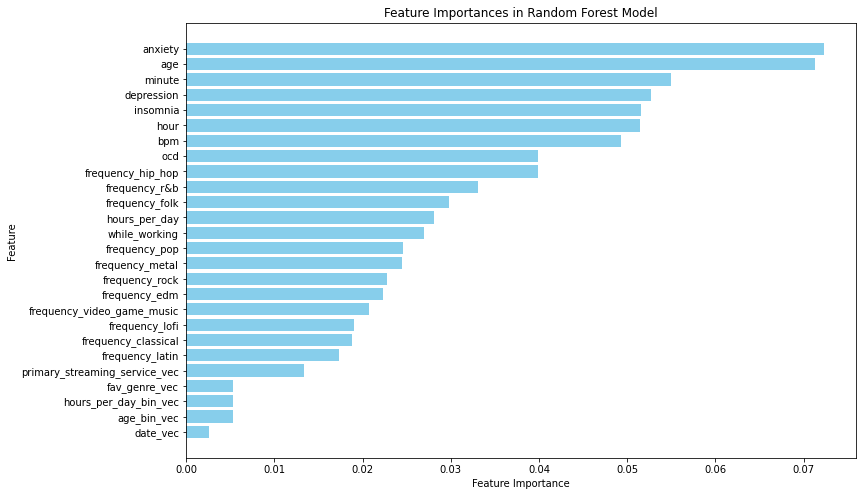

Precision: 0.7970857918501897
Recall: 0.7696335078534031


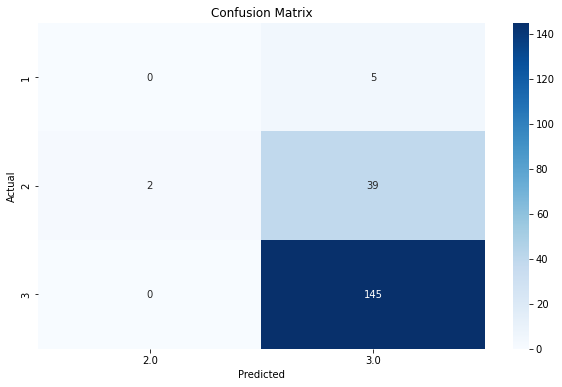

In [19]:
# Looking at feature importances from random forest 70/30 split model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances
feature_importances = best_model.stages[-1].featureImportances

# Get feature names
feature_names = assembler.getInputCols()

# Create a DataFrame for feature importances
importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# Display precision and recall
precision_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")

precision = precision_evaluator.evaluate(test_predictions)
recall = recall_evaluator.evaluate(test_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create a confusion matrix
actual = test_df.select("music_effects").toPandas()
predicted = test_predictions.select("prediction").toPandas()
confusion_matrix = pd.crosstab(actual["music_effects"], predicted["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


## 8.2 visualise data

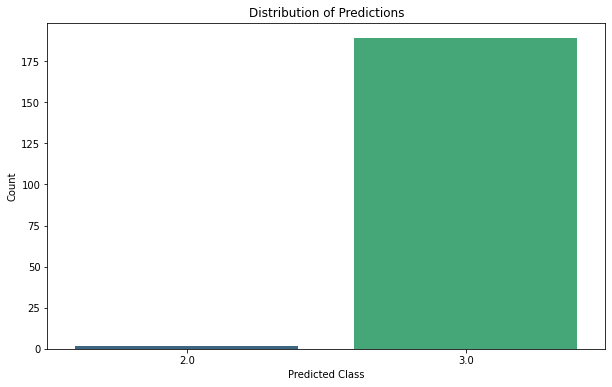

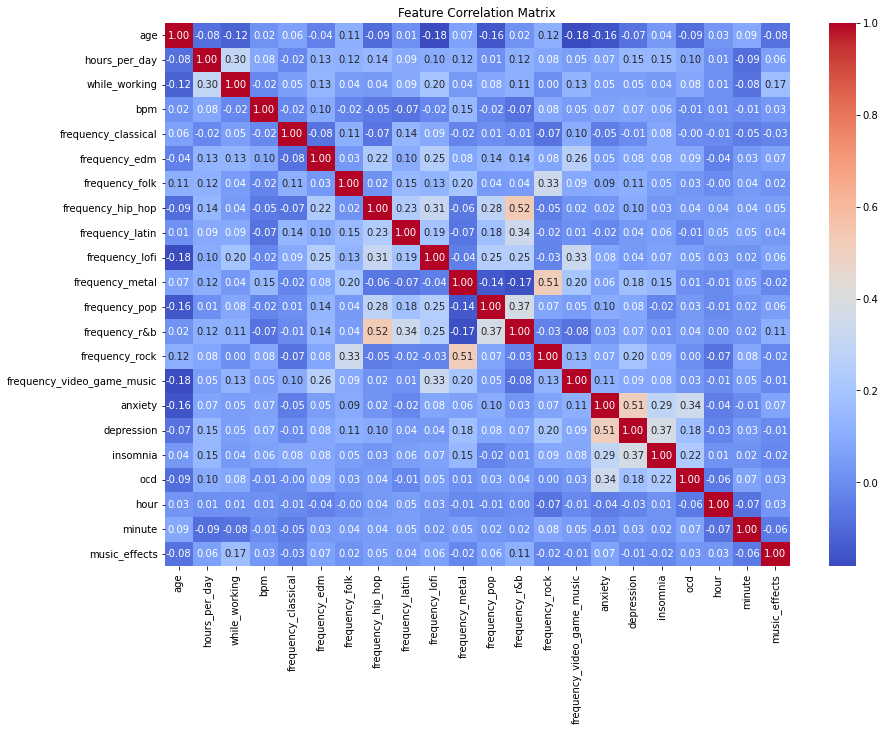

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/li

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         5
     Class 1       1.00      0.05      0.09        41
     Class 2       0.77      1.00      0.87       145

    accuracy                           0.77       191
   macro avg       0.59      0.35      0.32       191
weighted avg       0.80      0.77      0.68       191



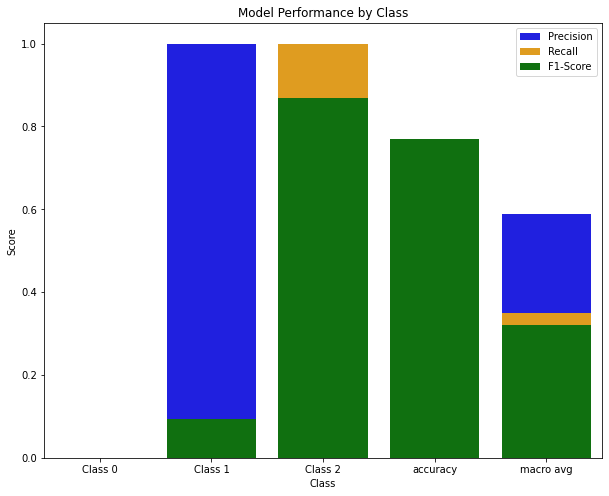

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Distribution of predictions
plt.figure(figsize=(10, 6))
sns.countplot(x="prediction", data=test_predictions.toPandas(), palette="viridis")
plt.title("Distribution of Predictions")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()

# Feature correlations
correlation_matrix = combined_transformed_df.toPandas()[feature_columns + ['music_effects']].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Generate classification report
actual = test_df.select("music_effects").toPandas()
predicted = test_predictions.select("prediction").toPandas()
report = classification_report(actual, predicted, target_names=["Class 0", "Class 1", "Class 2"])
print(report)

# Visualization of classification report
report_df = pd.DataFrame(classification_report(actual, predicted, target_names=["Class 0", "Class 1", "Class 2"], output_dict=True)).transpose()
plt.figure(figsize=(10, 8))
sns.barplot(x=report_df.index[:-1], y=report_df['precision'][:-1], color="blue", label="Precision")
sns.barplot(x=report_df.index[:-1], y=report_df['recall'][:-1], color="orange", label="Recall")
sns.barplot(x=report_df.index[:-1], y=report_df['f1-score'][:-1], color="green", label="F1-Score")
plt.title("Model Performance by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.show()


24/05/25 11:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB
24/05/25 11:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1210.2 KiB
24/05/25 11:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1267.7 KiB
24/05/25 11:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1253.8 KiB
24/05/25 11:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1174.4 KiB
24/05/25 11:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1066.1 KiB
24/05/25 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB
24/05/25 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1210.2 KiB
24/05/25 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1267.7 KiB
24/05/25 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1253.8 KiB
24/05/25 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1174.4 KiB
24/05/25 11:09:21 WAR

24/05/25 11:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.0 KiB
24/05/25 11:10:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.0 KiB
24/05/25 11:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB
24/05/25 11:10:50 WARN DAGScheduler: Broadcasting large task binary with size 1339.0 KiB
24/05/25 11:10:50 WARN DAGScheduler: Broadcasting large task binary with size 1852.6 KiB
24/05/25 11:10:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 11:10:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/25 11:10:51 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/25 11:10:52 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/25 11:10:54 WARN DAGScheduler: Broadcasting large task binary with size 1339.0 KiB
24/05/25 11:10:54 WARN DAGScheduler: Broadcasting large task binary with size 1852.6 KiB
24/05/25 11:10:54 WARN DAGSchedul

24/05/25 11:11:36 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/25 11:11:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1487.9 KiB
24/05/25 11:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1026.1 KiB
24/05/25 11:11:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/25 11:11:39 WARN DAGScheduler: Broadcasting large task binary with size 1312.6 KiB
24/05/25 11:11:39 WARN DAGScheduler: Broadcasting large task binary with size 1731.1 KiB
24/05/25 11:11:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 11:11:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 11:11:40 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/25 11:11:41 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 11:11:41 WARN DAGScheduler: Broad

24/05/25 11:13:15 WARN DAGScheduler: Broadcasting large task binary with size 1174.4 KiB
24/05/25 11:13:15 WARN DAGScheduler: Broadcasting large task binary with size 1446.8 KiB
24/05/25 11:13:15 WARN DAGScheduler: Broadcasting large task binary with size 1705.1 KiB
24/05/25 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1938.5 KiB
24/05/25 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 11:13:17 WARN DAGScheduler: Broadcasting large task binary with size 2022.8 KiB
24/05/25 11:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1712.3 KiB
24/05/25 11:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1345.0 KiB
24/05/25 11:13:17 WARN DAGSchedul

24/05/25 11:14:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 11:14:16 WARN DAGScheduler: Broadcasting large task binary with size 1347.2 KiB
24/05/25 11:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
24/05/25 11:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1292.0 KiB
24/05/25 11:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1501.4 KiB
24/05/25 11:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1611.3 KiB
24/05/25 11:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1503.2 KiB
24/05/25 11:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1051.1 KiB
24/05/25 11:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
24/05/25 11:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1292.0 KiB
24/05/25 11:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1501.4 KiB
24/05/25 11:14:21 WARN D

24/05/25 11:14:56 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/05/25 11:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1800.3 KiB
24/05/25 11:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1490.9 KiB
24/05/25 11:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1072.9 KiB
24/05/25 11:14:57 WARN DAGScheduler: Broadcasting large task binary with size 1495.6 KiB
24/05/25 11:14:58 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
24/05/25 11:14:58 WARN DAGScheduler: Broadcasting large task binary with size 1292.0 KiB
24/05/25 11:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1501.4 KiB
24/05/25 11:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1611.3 KiB
24/05/25 11:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1503.2 KiB
24/05/25 11:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1127.9 KiB
24/05/25 11:15:00 WARN D

24/05/25 11:16:27 WARN DAGScheduler: Broadcasting large task binary with size 1342.3 KiB
24/05/25 11:16:27 WARN DAGScheduler: Broadcasting large task binary with size 1944.0 KiB
24/05/25 11:16:29 WARN DAGScheduler: Broadcasting large task binary with size 1081.3 KiB
24/05/25 11:16:29 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB
24/05/25 11:16:29 WARN DAGScheduler: Broadcasting large task binary with size 1344.9 KiB
24/05/25 11:16:29 WARN DAGScheduler: Broadcasting large task binary with size 1377.1 KiB
24/05/25 11:16:30 WARN DAGScheduler: Broadcasting large task binary with size 1273.8 KiB
24/05/25 11:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1081.3 KiB
24/05/25 11:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB
24/05/25 11:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1344.9 KiB
24/05/25 11:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1377.1 KiB
24/05/25 11:16:32 WAR

24/05/25 11:17:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/25 11:17:36 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/25 11:17:36 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/05/25 11:17:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/25 11:17:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 11:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1808.2 KiB
24/05/25 11:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
24/05/25 11:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1065.8 KiB
24/05/25 11:17:37 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/25 11:17:39 WARN DAGScheduler: Broadcasting large task binary with size 1193.7 KiB
24/05/25 11:17:39 WARN DAGScheduler: Broadcasting large task binary with size 1641.6 KiB
24/05/25 11:17:39 WARN DAGScheduler: Br

24/05/25 11:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1412.2 KiB
24/05/25 11:19:03 WARN DAGScheduler: Broadcasting large task binary with size 1248.4 KiB
24/05/25 11:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1529.3 KiB
24/05/25 11:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1792.4 KiB
24/05/25 11:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1412.2 KiB
24/05/25 11:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1150.5 KiB
24/05/25 11:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1423.1 KiB
24/05/25 11:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1689.7 KiB
24/05/25 11:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1321.2 KiB
24/05/25 11:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.1 KiB
24/05/25 11:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1233.7 KiB
24/05/25 11:19:08 WAR

24/05/25 11:20:13 WARN DAGScheduler: Broadcasting large task binary with size 1988.9 KiB
24/05/25 11:20:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:20:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 11:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1496.2 KiB
24/05/25 11:20:16 WARN DAGScheduler: Broadcasting large task binary with size 1234.5 KiB
24/05/25 11:20:16 WARN DAGScheduler: Broadcasting large task binary with size 1612.7 KiB
24/05/25 11:20:16 WARN DAGScheduler: Broadcasting large task binary with size 1988.9 KiB
24/05/25 11:20:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:20:17 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 11:20:18 WARN DAGScheduler: Broadcasting large task binary with size 1496.2 KiB
24/05/25 11:20:19 WARN DAGScheduler: Broadcasting large task binary with size 1091.8 KiB
24/05/25 11:20:19 WARN DAGSchedul

24/05/25 11:20:57 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 11:20:57 WARN DAGScheduler: Broadcasting large task binary with size 1986.9 KiB
24/05/25 11:20:57 WARN DAGScheduler: Broadcasting large task binary with size 1437.9 KiB
24/05/25 11:20:58 WARN DAGScheduler: Broadcasting large task binary with size 1619.8 KiB
24/05/25 11:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1091.8 KiB
24/05/25 11:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1413.3 KiB
24/05/25 11:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1739.9 KiB
24/05/25 11:21:00 WARN DAGScheduler: Broadcasting large task binary with size 2018.5 KiB
24/05/25 11:21:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:21:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:21:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/25 11:21:01 WARN DAGSchedul

24/05/25 11:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1036.8 KiB
24/05/25 11:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1988.0 KiB
24/05/25 11:22:35 WARN DAGScheduler: Broadcasting large task binary with size 1196.9 KiB
24/05/25 11:22:35 WARN DAGScheduler: Broadcasting large task binary with size 1485.5 KiB
24/05/25 11:22:35 WARN DAGScheduler: Broadcasting large task binary with size 1770.0 KiB
24/05/25 11:22:35 WARN DAGScheduler: Broadcasting large task binary with size 2035.3 KiB
24/05/25 11:22:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:22:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 11:22:36 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/25 11:22:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/25 11:22:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/25 11:22:36 WARN DAGScheduler:

24/05/25 11:23:43 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/05/25 11:23:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 11:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1579.9 KiB
24/05/25 11:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1121.2 KiB
24/05/25 11:23:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/25 11:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1295.3 KiB
24/05/25 11:23:46 WARN DAGScheduler: Broadcasting large task binary with size 1787.0 KiB
24/05/25 11:23:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/25 11:23:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/25 11:23:47 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/25 11:23:47 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/25 11:23:48 WARN DAGScheduler: Broad

Best numTrees: 100
Best maxDepth: 10
Best minInstancesPerNode: 5
Best featureSubsetStrategy: auto
Test Accuracy: 0.7696335078534031
0    [0.0, 0.018416091428043457, 0.3036369650338547...
1    [0.0, 0.05077215397028848, 0.16868061394313463...
2    [0.0, 0.009446535540645626, 0.2058989964381902...
3    [0.0, 0.018787364282540353, 0.1856065310674962...
4    [0.0, 0.028544384918281457, 0.1278193008153116...
Name: probability, dtype: object


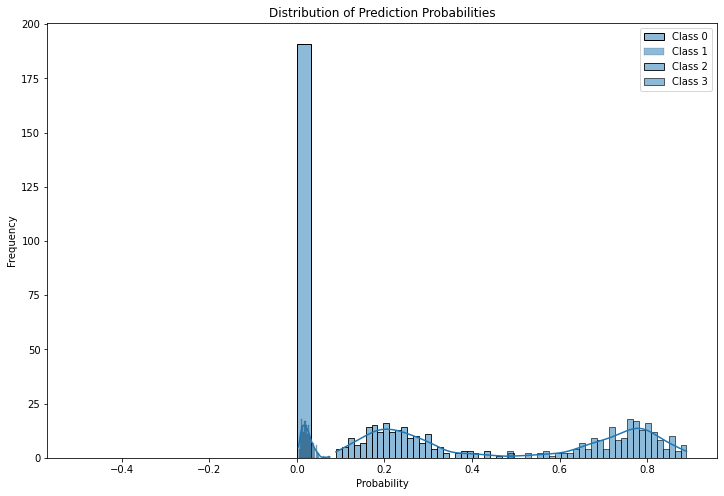

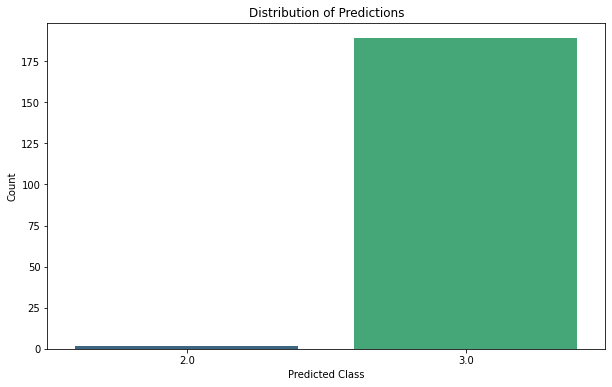

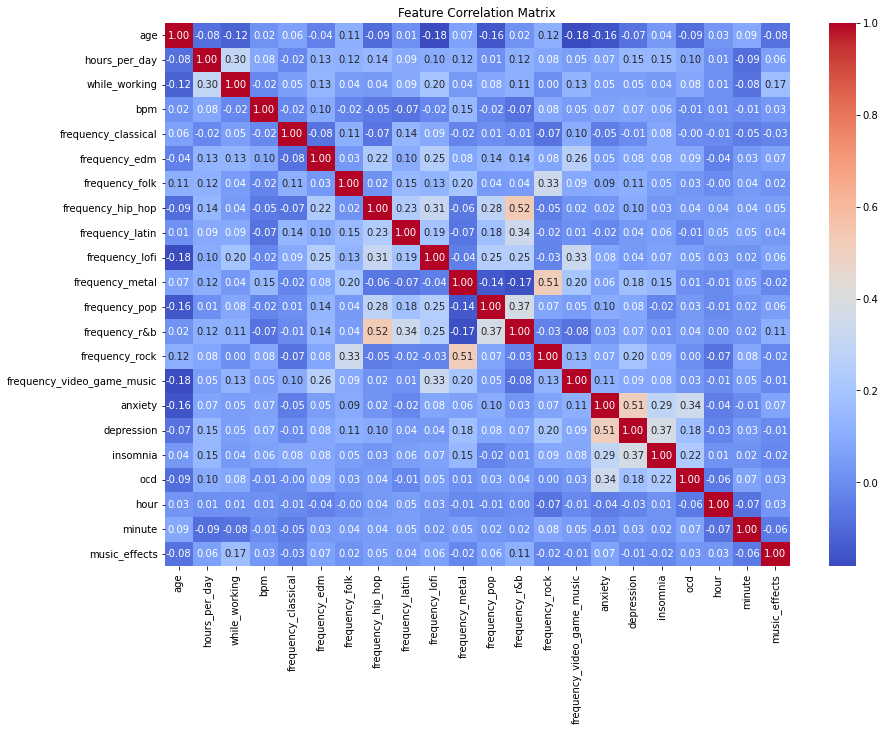

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         5
     Class 1       1.00      0.05      0.09        41
     Class 2       0.77      1.00      0.87       145

    accuracy                           0.77       191
   macro avg       0.59      0.35      0.32       191
weighted avg       0.80      0.77      0.68       191



/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/.local/li

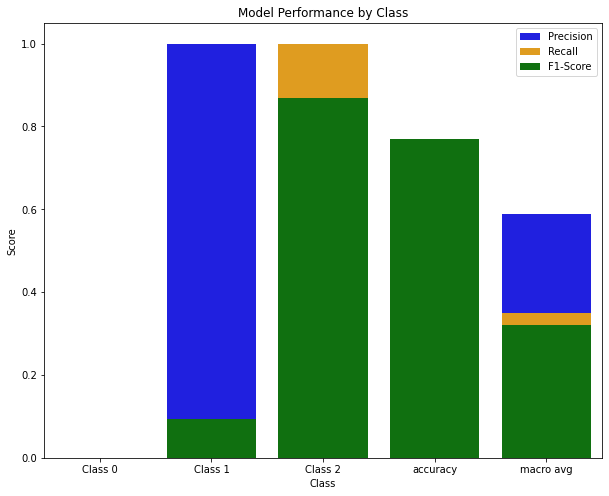

In [22]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Ensure the pipeline stages are correctly defined and applied
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.7, 0.3], seed=42)

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel

# Print the best parameters
print(f"Best numTrees: {best_model.stages[-1].getOrDefault('numTrees')}")
print(f"Best maxDepth: {best_model.stages[-1].getOrDefault('maxDepth')}")
print(f"Best minInstancesPerNode: {best_model.stages[-1].getOrDefault('minInstancesPerNode')}")
print(f"Best featureSubsetStrategy: {best_model.stages[-1].getOrDefault('featureSubsetStrategy')}")

# Evaluate the best model on the test set
test_predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")

# Inspect the probability column
probabilities = test_predictions.select("probability").toPandas()
print(probabilities['probability'].head())

# Assuming the probability column contains vectors of length 3
probability_length = len(probabilities['probability'][0])
columns = [f"Class {i}" for i in range(probability_length)]

# Create DataFrame
probabilities_df = pd.DataFrame(probabilities['probability'].tolist(), columns=columns)

# Plot distribution of prediction probabilities
plt.figure(figsize=(12, 8))
for i, col in enumerate(probabilities_df.columns):
    sns.histplot(probabilities_df[col], kde=True, label=f"Class {i}", bins=30)
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Distribution of predictions
plt.figure(figsize=(10, 6))
sns.countplot(x="prediction", data=test_predictions.toPandas(), palette="viridis")
plt.title("Distribution of Predictions")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()

# Feature correlations
correlation_matrix = combined_transformed_df.toPandas()[feature_columns + ['music_effects']].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Generate classification report
actual = test_df.select("music_effects").toPandas()
predicted = test_predictions.select("prediction").toPandas()
report = classification_report(actual, predicted, target_names=["Class 0", "Class 1", "Class 2"])
print(report)

# Visualization of classification report
report_df = pd.DataFrame(classification_report(actual, predicted, target_names=["Class 0", "Class 1", "Class 2"], output_dict=True)).transpose()
plt.figure(figsize=(10, 8))
sns.barplot(x=report_df.index[:-1], y=report_df['precision'][:-1], color="blue", label="Precision")
sns.barplot(x=report_df.index[:-1], y=report_df['recall'][:-1], color="orange", label="Recall")
sns.barplot(x=report_df.index[:-1], y=report_df['f1-score'][:-1], color="green", label="F1-Score")
plt.title("Model Performance by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.show()


# 6

In [12]:
#Decision tree
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

# Index string columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Assemble features into a vector
feature_columns = [col for col in combined_transformed_df.columns if col not in string_cols + ['music_effects']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the DecisionTree model
dt = DecisionTreeClassifier(labelCol="music_effects", featuresCol="features")

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, dt])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
dt_model = pipeline.fit(train_df)

# Make predictions
predictions = dt_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Decision Tree - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


Decision Tree - Accuracy: 0.7264957264957265, Precision: 0.7031802543724003, Recall: 0.7264957264957266


In [13]:
from xgboost import XGBClassifier
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.sql.functions import col
import pandas as pd
from sklearn.metrics import accuracy_score

# Convert PySpark DataFrame to Pandas DataFrame
train_pdf = train_df.toPandas()
test_pdf = test_df.toPandas()

# Extract features and labels
X_train = train_pdf[feature_columns]
y_train = train_pdf['music_effects']
X_test = test_pdf[feature_columns]
y_test = test_pdf['music_effects']

# Define and train the XGBoost model
xgb = XGBClassifier(objective='multi:softprob', num_class=3, max_depth=6, n_estimators=100)
xgb.fit(X_train, y_train)

# Make predictions
predictions = xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"XGBoost Accuracy: {accuracy}")

# Feature Importance
importances = xgb.feature_importances_
features_df = pd.DataFrame(list(zip(feature_columns, importances)), columns=["Feature", "Importance"])
features_df = features_df[features_df['Importance'] > 0.01]
print(features_df)


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [1 2 3]

In [14]:
#Multinomnia base
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Define feature columns and string columns
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical",
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin",
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b",
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression",
                   "insomnia", "ocd", "hour", "minute"]
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Index and encode string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the Logistic Regression model
lr = LogisticRegression(labelCol="music_effects", featuresCol="features", maxIter=100, family="multinomial")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
lr_model = pipeline.fit(train_df)

# Make predictions
predictions = lr_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Multinomial Logistic Regression - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


24/05/25 09:35:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/25 09:35:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/25 09:35:11 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/05/25 09:35:11 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Multinomial Logistic Regression - Accuracy: 0.6581196581196581, Precision: 0.612651898366184, Recall: 0.6581196581196582


In [15]:
#Kmeans clustering base 
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the KMeans model
kmeans = KMeans(featuresCol="features", k=3)

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, kmeans])

# Train the model
kmeans_model = pipeline.fit(combined_transformed_df)

# Make predictions
predictions = kmeans_model.transform(combined_transformed_df)

# Evaluate the model
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"K-Means Silhouette Score: {silhouette}")


K-Means Silhouette Score: 0.4721198334397441


In [12]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# List of feature columns
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]

# String columns to be indexed and one-hot encoded
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the DecisionTree model
dt = DecisionTreeClassifier(labelCol="music_effects", featuresCol="features")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, dt])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 20])
             .addGrid(dt.minInstancesPerNode, [1, 5, 10])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")

# Define the cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel

# Print the best parameters
print(f"Best maxDepth: {best_model.stages[-1].getMaxDepth()}")
print(f"Best minInstancesPerNode: {best_model.stages[-1].getMinInstancesPerNode()}")

# Evaluate the best model on the test set
test_predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")

# Evaluate precision and recall
evaluator_precision = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")

precision = evaluator_precision.evaluate(test_predictions)
recall = evaluator_recall.evaluate(test_predictions)

print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")


Best maxDepth: 5
Best minInstancesPerNode: 10
Test Accuracy: 0.7435897435897436
Test Precision: 0.6883629191321499
Test Recall: 0.7435897435897436


In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

# Index string columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Assemble features into a vector
feature_columns = [col for col in combined_transformed_df.columns if col not in string_cols + ['music_effects']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the DecisionTree model
dt = DecisionTreeClassifier(labelCol="music_effects", featuresCol="features")

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, dt])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
dt_model = pipeline.fit(train_df)

# Make predictions
predictions = dt_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Decision Tree - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


Decision Tree - Accuracy: 0.7264957264957265, Precision: 0.7031802543724003, Recall: 0.7264957264957266


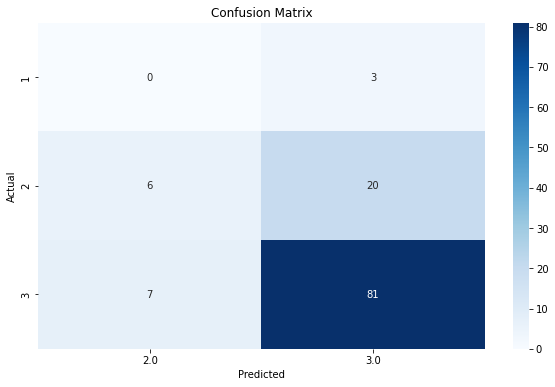

In [15]:
import seaborn as sns

# Extract actual and predicted values
actual = test_df.select("music_effects").toPandas()
predicted = test_predictions.select("prediction").toPandas()

# Create a confusion matrix
confusion_matrix = pd.crosstab(actual["music_effects"], predicted["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define evaluators
precision_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")

# Evaluate precision and recall
precision = precision_evaluator.evaluate(test_predictions)
recall = recall_evaluator.evaluate(test_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 0.6883629191321499
Recall: 0.7435897435897436


24/05/25 05:50:50 WARN Instrumentation: [b56960a3] All labels are the same value and fitIntercept=true, so the coefficients will be zeros. Training is not needed.


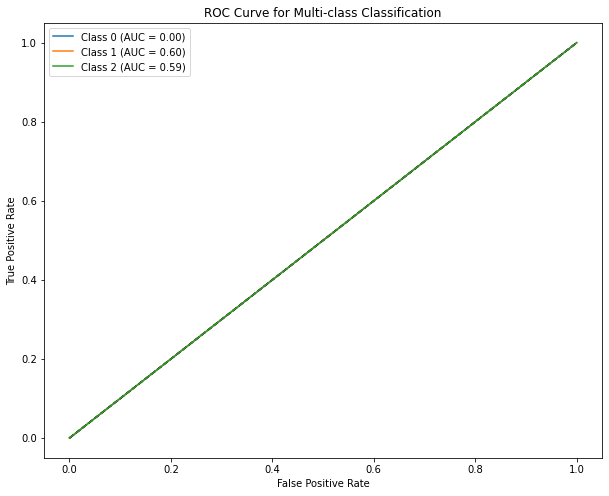

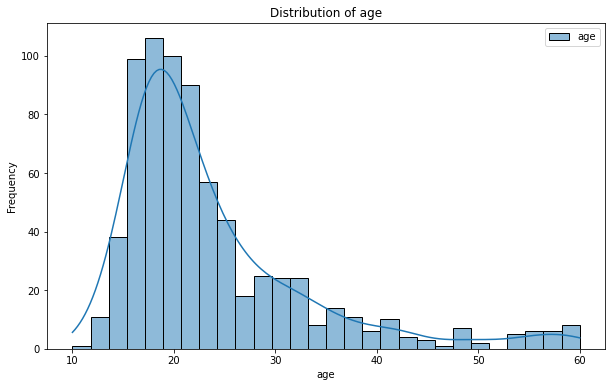

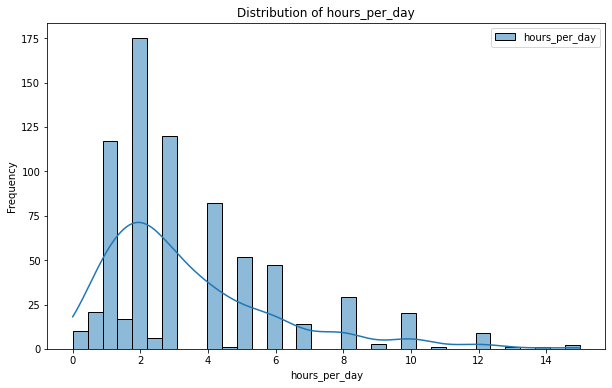

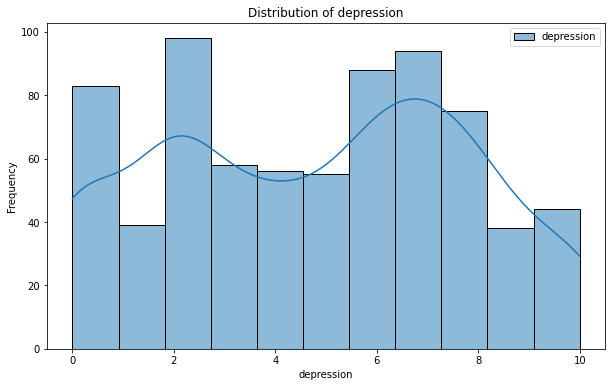

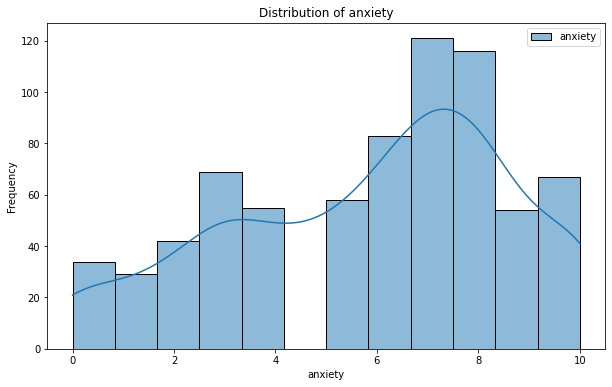

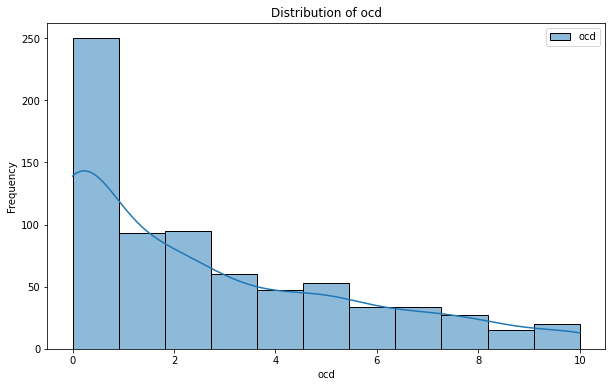

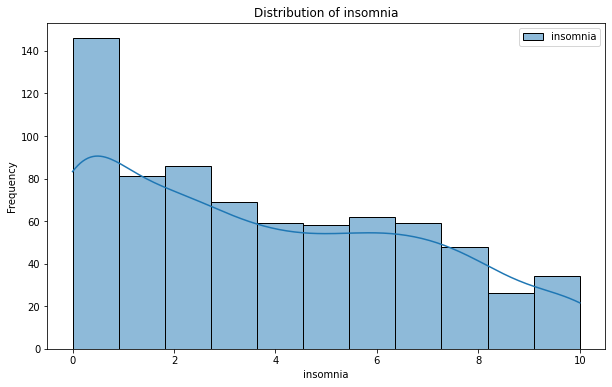

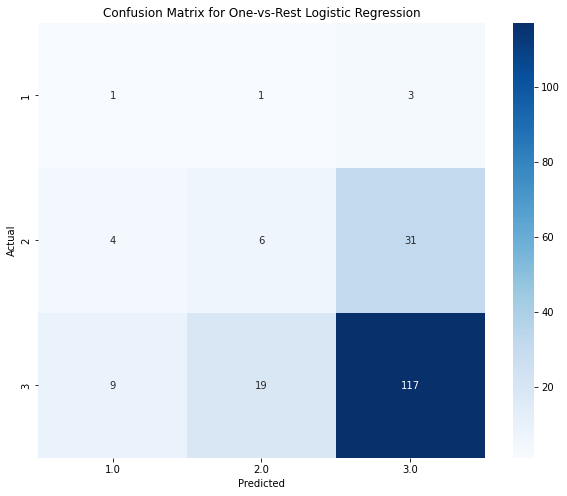

In [16]:
#BinaryClassificationEvaluator 
from pyspark.ml.classification import OneVsRest, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
import pandas as pd

# Define string columns and feature columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Transform the data to include the 'features' column
transformed_df = pipeline.fit(combined_transformed_df).transform(combined_transformed_df)

# Train-test split
train_df, test_df = transformed_df.randomSplit([0.7, 0.3], seed=42)

# Define the base classifier for OvR
lr = LogisticRegression(featuresCol="features", labelCol="music_effects")

# Define the One-vs-Rest classifier
ovr = OneVsRest(classifier=lr, labelCol="music_effects")

# Train the One-vs-Rest model
ovr_model = ovr.fit(train_df)

# Make predictions
ovr_predictions = ovr_model.transform(test_df)

# Evaluate the model using BinaryClassificationEvaluator
roc_evaluators = []
for i in range(3):  # Assuming 3 classes
    evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    test_predictions_class = ovr_predictions.withColumn("binary_label", F.when(F.col("music_effects") == i, 1).otherwise(0))
    auc = evaluator.evaluate(test_predictions_class)
    roc_evaluators.append((i, auc))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for label, auc in roc_evaluators:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, auc, 1], [0, auc, 1], label=f'Class {label} (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='best')
plt.show()

# Plotting distribution of a few key features
key_features = ["age", "hours_per_day", "depression", "anxiety", "ocd", "insomnia"]

for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_transformed_df.select(feature).toPandas(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Additional visualization: Confusion matrix heatmap
# Convert predictions to Pandas DataFrame
actual = test_df.select("music_effects").toPandas()
predicted = ovr_predictions.select("prediction").toPandas()

# Create a confusion matrix using pandas
conf_matrix = pd.crosstab(actual["music_effects"], predicted["prediction"], rownames=["Actual"], colnames=["Predicted"])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for One-vs-Rest Logistic Regression')
plt.show()


In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# List of feature columns
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical",
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin",
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b",
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression",
                   "insomnia", "ocd", "hour", "minute"]

# String columns to be indexed and one-hot encoded
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")

# Define the DecisionTree model
dt = DecisionTreeClassifier(labelCol="music_effects", featuresCol="features")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, dt])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 20])
             .addGrid(dt.minInstancesPerNode, [1, 5, 10])
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")

# Define the cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel

# Print the best parameters
print(f"Best maxDepth: {best_model.stages[-1].getMaxDepth()}")
print(f"Best minInstancesPerNode: {best_model.stages[-1].getMinInstancesPerNode()}")

# Evaluate the best model on the test set
test_predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")

# Evaluate precision and recall
evaluator_precision = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="weightedRecall")

precision = evaluator_precision.evaluate(test_predictions)
recall = evaluator_recall.evaluate(test_predictions)

print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")


Best maxDepth: 5
Best minInstancesPerNode: 1
Test Accuracy: 0.7350427350427351
Test Precision: 0.6920086880482921
Test Recall: 0.7350427350427351


## 8.5

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline

# Initialize Spark session
spark = SparkSession.builder.appName("Iteration2").getOrCreate()

# Importing datasets as pyspark dataframe
df = spark.read.format("csv") \
             .option("header", "true") \
             .option("inferSchema", "true") \
             .load("joined04.csv")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/26 11:16:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql.functions import col

# Convert categorical variables, ensures statistical methods that are sensitive to data types treat these variables correctly. Prepare for encoding
categorical_cols = ['age_bin', 'while_working']
for col_name in categorical_cols:
    df = df.withColumn(col_name, col(col_name).cast('string'))

# Calculate genre popularity score within each age group
# Using genre frequency columns for the calculation
genre_columns = [col for col in df.columns if 'frequency' in col and 'popularity' not in col]
df_genres = df.select(['age_bin'] + genre_columns).toPandas().melt(id_vars=['age_bin'], var_name='genre', value_name='frequency')

# Melts df to convert from wide to long format
genre_popularity_score = df_genres.groupby(['age_bin', 'genre'])['frequency'].mean().reset_index()

# Calculates mean frequency of each genre in each age group
# Reshape the genre popularity data to wide format, ensuring unique column names
genre_popularity_score = genre_popularity_score.pivot(index='age_bin', columns='genre', values='frequency')
genre_popularity_score.columns = ['Age group popularity frequency ' + col.replace('_', ' ') for col in genre_popularity_score.columns]

# Convert back to spark df and join the popularity scores back to the main df using the index (age group)
genre_popularity_score = spark.createDataFrame(genre_popularity_score.reset_index())
df = df.join(genre_popularity_score, on='age_bin', how='left')

# Display the DataFrame to confirm changes
df.select(['age_bin'] + genre_popularity_score.columns).show()
#df.show()
df.printSchema()

+-------+-------+--------------------------------------------------+------------------------------------------------+--------------------------------------------+---------------------------------------------+-----------------------------------------------+------------------------------------------------+---------------------------------------------+----------------------------------------------+----------------------------------------------+---------------------------------------------+----------------------------------------------+--------------------------------------------+--------------------------------------------+--------------------------------------------+---------------------------------------------+---------------------------------------------------------+
|age_bin|age_bin|Age group popularity frequency frequency classical|Age group popularity frequency frequency country|Age group popularity frequency frequency edm|Age group popularity frequency frequency folk|Age group popu

In [4]:
# List of new columns to rename to lower case
new_columns = [
    "Age group popularity frequency frequency classical", "Age group popularity frequency frequency country",
    "Age group popularity frequency frequency edm", "Age group popularity frequency frequency folk",
    "Age group popularity frequency frequency gospel", "Age group popularity frequency frequency hip hop",
    "Age group popularity frequency frequency jazz", "Age group popularity frequency frequency k pop",
    "Age group popularity frequency frequency latin", "Age group popularity frequency frequency lofi",
    "Age group popularity frequency frequency metal", "Age group popularity frequency frequency pop",
    "Age group popularity frequency frequency r&b", "Age group popularity frequency frequency rap",
    "Age group popularity frequency frequency rock", "Age group popularity frequency frequency video game music"
]

# Create a dictionary to map old column names to new column names
rename_dict = {col_name: col_name.lower().replace(' ', '_') for col_name in new_columns}

# Rename the columns
for old_col, new_col in rename_dict.items():
    df = df.withColumnRenamed(old_col, new_col)

In [5]:
from pyspark.sql.functions import col, expr, when, sum as spark_sum

# Define the list of genres based on your dataset columns
genre_list = [
    "classical", "country", "edm", "folk", "gospel", "hip_hop", 
    "jazz", "k_pop", "latin", "lofi", "metal", "pop", "r&b", 
    "rap", "rock", "video_game_music"
]

# Mental health conditions aggregated into one score
df = df.withColumn("mental_health_severity", col("anxiety") + col("depression") + col("insomnia") + col("ocd"))

# Mental health converted into categorical values
df = df.withColumn("anxiety_level", when(col("anxiety") < 3, "low").when(col("anxiety") < 6, "medium").otherwise("high"))
df = df.withColumn("depression_level", when(col("depression") < 3, "low").when(col("depression") < 6, "medium").otherwise("high"))
df = df.withColumn("insomnia_level", when(col("insomnia") < 3, "low").when(col("insomnia") < 6, "medium").otherwise("high"))
df = df.withColumn("ocd_level", when(col("ocd") < 3, "low").when(col("ocd") < 6, "medium").otherwise("high"))

# Streaming service popularity by age group, counting number of occurances of each streaming service within each age group
df_service_popularity = df.groupBy("age_bin", "primary_streaming_service").count()
df = df.join(df_service_popularity, on=["age_bin", "primary_streaming_service"], how="left")

# Music effects by time of day
df = df.withColumn("morning_listening", when(col("hour") < 12, 1).otherwise(0))
df = df.withColumn("afternoon_listening", when((col("hour") >= 12) & (col("hour") < 18), 1).otherwise(0))
df = df.withColumn("evening_listening", when(col("hour") >= 18, 1).otherwise(0))


# Display the DataFrame to confirm changes
#df.show()

In [60]:
# from pyspark.sql import SparkSession
# import os
# import shutil


# # Define the temporary directory and final CSV file path
# temp_directory = "./temp_csv"
# final_csv_path = "8.5_01_final_output.csv"

# # Save the PySpark DataFrame to a temporary directory
# df.coalesce(1).write.csv(temp_directory, header=True)

# # Find the part file (the CSV file)
# part_file = [f for f in os.listdir(temp_directory) if f.startswith("part-") and f.endswith(".csv")][0]

# # Move the part file to the desired final location
# shutil.move(os.path.join(temp_directory, part_file), final_csv_path)

# # Clean up the temporary directory
# shutil.rmtree(temp_directory)

# print(f"CSV file saved to {final_csv_path}")

CSV file saved to 8.5_01_final_output.csv


In [48]:
# Importing datasets as pyspark dataframe
df = spark.read.format("csv") \
             .option("header", "true") \
             .option("inferSchema", "true") \
             .load("8.5_01_final_output.csv")

In [13]:
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df.toPandas()

# Calculate the number of null values in each column
null_counts = df_pandas.isnull().sum()

# Print the number of null values in each column
print("Null values in each column:")
print(null_counts)

# Get a concise summary of the DataFrame, including non-null counts and data types
print("\nColumn information:")
df_pandas.info()


Null values in each column:
age_bin                      0
primary_streaming_service    0
unique_id                    0
age                          0
hours_per_day                0
                            ..
ocd_level                    0
count                        0
morning_listening            0
afternoon_listening          0
evening_listening            0
Length: 62, dtype: int64

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 62 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   age_bin                                                    728 non-null    object 
 1   primary_streaming_service                                  728 non-null    object 
 2   unique_id                                                  728 non-null    int32  
 3   age                                

<Figure size 864x432 with 0 Axes>

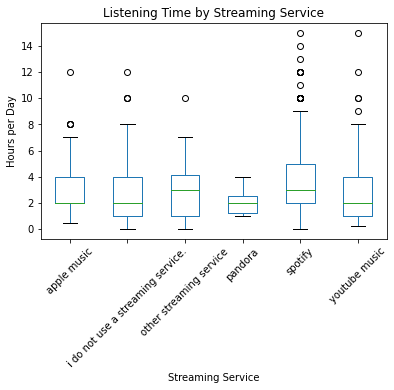

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df.toPandas()

# Boxplot for hours_per_day by primary_streaming_service
plt.figure(figsize=(12, 6))
df_pandas.boxplot(column='hours_per_day', by='primary_streaming_service', grid=False)
plt.title('Listening Time by Streaming Service')
plt.suptitle('')
plt.xlabel('Streaming Service')
plt.ylabel('Hours per Day')
plt.xticks(rotation=45)
plt.show()



### balancing 

In [49]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Class balancing
class_counts = df.groupBy("music_effects").count().collect()
class_counts_dict = {row['music_effects']: row['count'] for row in class_counts}

max_count = max(class_counts_dict.values())

def balance_classes(df, class_counts, max_count):
    sampled_dfs = []
    for cls, count in class_counts.items():
        if count < max_count:
            fraction = max_count / count
            sampled_df = df.filter(col("music_effects") == cls).sample(withReplacement=True, fraction=fraction, seed=42)
        else:
            sampled_df = df.filter(col("music_effects") == cls)
        sampled_dfs.append(sampled_df)
    return sampled_dfs

sampled_dfs = balance_classes(df, class_counts_dict, max_count)
balanced_df = sampled_dfs[0]
for sampled_df in sampled_dfs[1:]:
    balanced_df = balanced_df.union(sampled_df)

# Remove the `count` column if it exists
if 'count' in balanced_df.columns:
    balanced_df = balanced_df.drop('count')

# Verify the class balancing
balanced_df.groupBy("music_effects").count().show()

+-------------+-----+
|music_effects|count|
+-------------+-----+
|            1|  524|
|            3|  546|
|            2|  542|
+-------------+-----+



In [23]:
balanced_df.printSchema()

root
 |-- age_bin: string (nullable = true)
 |-- primary_streaming_service: string (nullable = true)
 |-- unique_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- hours_per_day: double (nullable = true)
 |-- while_working: integer (nullable = true)
 |-- instrumentalist: integer (nullable = true)
 |-- composer: integer (nullable = true)
 |-- fav_genre: string (nullable = true)
 |-- exploratory: integer (nullable = true)
 |-- foreign_languages: integer (nullable = true)
 |-- bpm: double (nullable = true)
 |-- frequency_classical: integer (nullable = true)
 |-- frequency_country: integer (nullable = true)
 |-- frequency_edm: integer (nullable = true)
 |-- frequency_folk: integer (nullable = true)
 |-- frequency_gospel: integer (nullable = true)
 |-- frequency_hip_hop: integer (nullable = true)
 |-- frequency_jazz: integer (nullable = true)
 |-- frequency_k_pop: integer (nullable = true)
 |-- frequency_latin: integer (nullable = true)
 |-- frequency_lofi: integer (null

In [50]:
# from pyspark.sql import SparkSession
# import os
# import shutil


# # Define the temporary directory and final CSV file path
# temp_directory = "./temp_csv"
# final_csv_path = "balanced_df.csv"

# # Save the PySpark DataFrame to a temporary directory
# df.coalesce(1).write.csv(temp_directory, header=True)

# # Find the part file (the CSV file)
# part_file = [f for f in os.listdir(temp_directory) if f.startswith("part-") and f.endswith(".csv")][0]

# # Move the part file to the desired final location
# shutil.move(os.path.join(temp_directory, part_file), final_csv_path)

# # Clean up the temporary directory
# shutil.rmtree(temp_directory)

# print(f"CSV file saved to {final_csv_path}")

CSV file saved to balanced_df.csv


In [68]:
# Importing datasets as pyspark dataframe
df = spark.read.format("csv") \
             .option("header", "true") \
             .option("inferSchema", "true") \
             .load("balanced_df.csv")

In [69]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("FeatureSelection").getOrCreate()

# Define the columns for transformations
continuous_columns = [
    "hours_per_day", "bpm",
    "age_group_popularity_frequency_frequency_classical", "age_group_popularity_frequency_frequency_country",
    "age_group_popularity_frequency_frequency_edm", "age_group_popularity_frequency_frequency_folk",
    "age_group_popularity_frequency_frequency_gospel", "age_group_popularity_frequency_frequency_hip_hop",
    "age_group_popularity_frequency_frequency_jazz", "age_group_popularity_frequency_frequency_k_pop",
    "age_group_popularity_frequency_frequency_latin", "age_group_popularity_frequency_frequency_lofi",
    "age_group_popularity_frequency_frequency_metal", "age_group_popularity_frequency_frequency_pop",
    "age_group_popularity_frequency_frequency_r&b", "age_group_popularity_frequency_frequency_rap",
    "age_group_popularity_frequency_frequency_rock", "age_group_popularity_frequency_frequency_video_game_music",
]

integer_columns = [
    "frequency_classical", "frequency_country", "frequency_edm", "frequency_folk", "frequency_gospel",
    "frequency_hip_hop", "frequency_jazz", "frequency_k_pop", "frequency_latin", "frequency_lofi",
    "frequency_metal", "frequency_pop", "frequency_r&b", "frequency_rap", "frequency_rock",
    "frequency_video_game_music", "while_working", "instrumentalist", "composer", "exploratory",
    "foreign_languages", "morning_listening", "afternoon_listening", "evening_listening", "age",
    "anxiety", "depression", "insomnia",
    "ocd", "hour", "minute", "mental_health_severity"
]

# Define the categorical columns
categorical_columns = [
    'primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date',
    'anxiety_level', 'depression_level', 'insomnia_level', 'ocd_level'
]

# Apply StringIndexer to categorical columns
indexers = []
for c in categorical_columns:
    index_col = f"{c}_indexed"
    if index_col not in balanced_df.columns:
        indexers.append(StringIndexer(inputCol=c, outputCol=index_col))

# Create a pipeline for indexing
pipeline_indexers = Pipeline(stages=indexers)

# Fit and transform the data if there are indexers
if indexers:
    df_indexed = pipeline_indexers.fit(balanced_df).transform(balanced_df)
else:
    df_indexed = balanced_df

# Remove existing 'features' column if it exists
if 'features' in df_indexed.columns:
    df_indexed = df_indexed.drop('features')

# Assemble the indexed categorical columns and other columns into the feature vector
assembler = VectorAssembler(
    inputCols=[f"{c}_indexed" for c in categorical_columns if f"{c}_indexed" in df_indexed.columns] + continuous_columns + integer_columns,
    outputCol="features"
)
df_indexed = assembler.transform(df_indexed)

# Calculate the correlation matrix
corr_matrix = Correlation.corr(df_indexed, "features").head()[0].toArray()

# Extract the correlation of each feature with the target variable
target_corr = corr_matrix[-1, :-1]

# Ensure lengths match between features and correlations
features = [f"{c}_indexed" for c in categorical_columns if f"{c}_indexed" in df_indexed.columns] + continuous_columns + integer_columns
features = features[:len(target_corr)]

# Create a DataFrame for feature correlations
feature_corr_df = pd.DataFrame({
    'feature': features,
    'correlation': target_corr
})

# Print correlation values for each feature
print("Correlation values for each feature:")
print(feature_corr_df)

# Filter features based on the correlation threshold
threshold = 0.01
selected_features_indexed = feature_corr_df[feature_corr_df['correlation'].abs() >= threshold]['feature'].tolist()

# Map back to original categorical features
selected_features = []
for feature in selected_features_indexed:
    if feature.endswith('_indexed'):
        original_feature = feature.replace('_indexed', '')
        selected_features.append(original_feature)
    else:
        selected_features.append(feature)

selected_features.append("music_effects")

# Print the selected features
print(f"Selected features with correlation >= {threshold}:")
print(selected_features)

# Create a new DataFrame with the selected features
df_reduced = df_indexed.select(*selected_features)

# Show the new DataFrame schema and a few rows to verify
df_reduced.printSchema()
df_reduced.show()

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Correlation values for each feature:
                                              feature  correlation
0                   primary_streaming_service_indexed    -0.154641
1                                   fav_genre_indexed    -0.153560
2                                     age_bin_indexed    -0.082811
3                           hours_per_day_bin_indexed     0.036042
4                                        date_indexed    -0.039790
5                               anxiety_level_indexed    -0.686632
6                            depression_level_indexed    -0.438773
7                              insomnia_level_indexed     0.336800
8                                   ocd_level_indexed     0.561338
9                                       hours_per_day     0.070730
10                                                bpm     0.107633
11  age_group_popularity_frequency_frequency_class...    -0.065312
12   age_group_popularity_frequency_frequency_country    -0.073012
13       age_group_popula

+-------------------------+---------+-------+-----------------+----------+-------------+----------------+--------------+---------+-------------+-----+--------------------------------------------------+------------------------------------------------+--------------------------------------------+---------------------------------------------+-----------------------------------------------+------------------------------------------------+---------------------------------------------+----------------------------------------------+---------------------------------------------+----------------------------------------------+--------------------------------------------+--------------------------------------------+--------------------------------------------+---------------------------------------------+---------------------------------------------------------+-------------------+-----------------+-------------+--------------+----------------+-----------------+--------------+---------------+----

In [70]:
# from pyspark.sql import SparkSession
# import os
# import shutil


# # Define the temporary directory and final CSV file path
# temp_directory = "./temp_csv"
# final_csv_path = "85_features.csv"

# # Save the PySpark DataFrame to a temporary directory
# df.coalesce(1).write.csv(temp_directory, header=True)

# # Find the part file (the CSV file)
# part_file = [f for f in os.listdir(temp_directory) if f.startswith("part-") and f.endswith(".csv")][0]

# # Move the part file to the desired final location
# shutil.move(os.path.join(temp_directory, part_file), final_csv_path)

# # Clean up the temporary directory
# shutil.rmtree(temp_directory)

# print(f"CSV file saved to {final_csv_path}")

CSV file saved to 85_features.csv


In [16]:
# Importing datasets as pyspark dataframe
df = spark.read.format("csv") \
             .option("header", "true") \
             .option("inferSchema", "true") \
             .load("85_features.csv")

ConnectionRefusedError: [Errno 111] Connection refused

In [14]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col as spark_col
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from scipy.stats import skew, kurtosis, yeojohnson, boxcox


# Load the dataframe
df_spark = df

# Define continuous and integer columns for transformations
continuous_columns = [
    "hours_per_day", "bpm",
    "age_group_popularity_frequency_frequency_classical", "age_group_popularity_frequency_frequency_country",
    "age_group_popularity_frequency_frequency_edm", "age_group_popularity_frequency_frequency_folk",
    "age_group_popularity_frequency_frequency_gospel", "age_group_popularity_frequency_frequency_hip_hop",
    "age_group_popularity_frequency_frequency_jazz", "age_group_popularity_frequency_frequency_k_pop",
    "age_group_popularity_frequency_frequency_latin", "age_group_popularity_frequency_frequency_lofi",
    "age_group_popularity_frequency_frequency_metal", "age_group_popularity_frequency_frequency_pop",
    "age_group_popularity_frequency_frequency_r&b", "age_group_popularity_frequency_frequency_rap",
    "age_group_popularity_frequency_frequency_rock", "age_group_popularity_frequency_frequency_video_game_music"
]

integer_columns = [
    "frequency_classical", "frequency_country", "frequency_edm", "frequency_folk", "frequency_gospel",
    "frequency_hip_hop", "frequency_jazz", "frequency_k_pop", "frequency_latin", "frequency_lofi",
    "frequency_metal", "frequency_pop", "frequency_r&b", "frequency_rap", "frequency_rock",
    "frequency_video_game_music", "while_working", "instrumentalist", "composer", "exploratory",
    "foreign_languages", "morning_listening", "afternoon_listening", "evening_listening",
    "age", "anxiety", "depression", "insomnia", "ocd", "hour", "minute", "mental_health_severity"
]

# Define categorical columns
categorical_columns = [
    'primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date',
    'anxiety_level', 'depression_level', 'insomnia_level', 'ocd_level'
]

# Ensure numeric columns are of DoubleType for transformations
for column in continuous_columns + integer_columns:
    df_spark = df_spark.withColumn(column, col(column).cast(DoubleType()))

# Function to calculate skewness and kurtosis
def calculate_statistics_spark(df, columns):
    stats = {}
    for column in columns:
        skew_val = df.select(skewness(col(column)).alias(f"{column}_skewness")).collect()[0][0]
        kurt_val = df.select(kurtosis(col(column)).alias(f"{column}_kurtosis")).collect()[0][0]
        stats[column] = {
            'skewness': skew_val,
            'kurtosis': kurt_val
        }
    return pd.DataFrame(stats).T

# Function to apply Yeo-Johnson transformation
def apply_yeojohnson(df, columns):
    numeric_df = df.select(columns + ['music_effects']).toPandas()
    transformed_data = numeric_df.copy()
    for column in columns:
        transformed_data[f"{column}_yeojohnson"], _ = yeojohnson(numeric_df[column].astype(float))
    return spark.createDataFrame(transformed_data)

# Function to apply Box-Cox transformation
def apply_boxcox(df, columns):
    numeric_df = df.select(columns + ['music_effects']).toPandas()
    transformed_data = numeric_df.copy()
    for column in columns:
        positive_data = numeric_df[column] + 1 - numeric_df[column].min()
        transformed_data[f"{column}_boxcox"], _ = boxcox(positive_data)
    return spark.createDataFrame(transformed_data)

# Apply Yeo-Johnson and Box-Cox transformations
df_yeojohnson = apply_yeojohnson(df_spark, continuous_columns + integer_columns)
df_boxcox = apply_boxcox(df_spark, continuous_columns + integer_columns)

# Calculate statistics after transformation
stats_after_yj = calculate_statistics_spark(df_yeojohnson, [f"{col}_yeojohnson" for col in continuous_columns + integer_columns])
stats_after_bc = calculate_statistics_spark(df_boxcox, [f"{col}_boxcox" for col in continuous_columns + integer_columns])

# Select the best transformation for each column
best_transformations = {}
for col in continuous_columns + integer_columns:
    yj_skew = stats_after_yj.loc[f"{col}_yeojohnson", 'skewness']
    yj_kurt = stats_after_yj.loc[f"{col}_yeojohnson", 'kurtosis']
    bc_skew = stats_after_bc.loc[f"{col}_boxcox", 'skewness']
    bc_kurt = stats_after_bc.loc[f"{col}_boxcox", 'kurtosis']
    
    # Calculate how close skewness and kurtosis are to 0 and 3, respectively
    yj_score = abs(yj_skew) + abs(yj_kurt - 3)
    bc_score = abs(bc_skew) + abs(bc_kurt - 3)
    
    if yj_score < bc_score:
        best_transformations[col] = f"{col}_yeojohnson"
    else:
        best_transformations[col] = f"{col}_boxcox"

# Apply StringIndexer to categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed") for c in categorical_columns]

# Assemble the transformation pipeline for categorical columns
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df_spark).transform(df_spark)

# Join the best transformations into the final DataFrame
best_transformations_list = list(best_transformations.values())
df_final = df_indexed.join(
    df_yeojohnson.select([col for col in best_transformations_list if col.endswith('_yeojohnson')] + ['music_effects']),
    on='music_effects',
    how='left'
).join(
    df_boxcox.select([col for col in best_transformations_list if col.endswith('_boxcox')] + ['music_effects']),
    on='music_effects',
    how='left'
)

# Drop duplicate columns
df_final = df_final.dropDuplicates()

# Calculate final skewness and kurtosis
stats_final = calculate_statistics_spark(df_final, best_transformations_list)

# Output the final skewness and kurtosis statistics
print("Final Skewness and Kurtosis After Selecting Best Transformations:")
print(stats_final)


TypeError: 'str' object is not callable

In [78]:
df_pandas = df_final.toPandas()

# Display summary statistics
summary_stats = df_pandas.describe()
print(summary_stats)

# Display summary statistics
summary_stats = df_pandas.describe()
print(summary_stats)

# Print the number of null values in each column
print("Null values in each column:")
print(null_counts)

# Get a concise summary of the DataFrame, including non-null counts and data types
print("\nColumn information:")
df_pandas.info()

ConnectionRefusedError: [Errno 111] Connection refused

In [26]:
# Convert Spark DataFrame to Pandas DataFrame for visualization purposes
df_pandas = df_final.toPandas()

# Display summary statistics
summary_stats = df_pandas.describe()
print(summary_stats)

# Display summary statistics
summary_stats = df_pandas.describe()
print(summary_stats)

# Print the number of null values in each column
print("Null values in each column:")
print(null_counts)

# Get a concise summary of the DataFrame, including non-null counts and data types
print("\nColumn information:")
df_pandas.info()


              age  hours_per_day         bpm  frequency_classical  \
count  728.000000     728.000000  728.000000           728.000000   
mean     0.784556       1.189293    5.262080             1.524941   
std      0.005646       0.430650    0.294782             0.496948   
min      0.761122      -0.000000    4.315926             0.804503   
25%      0.780997       1.008983    5.086451             1.395757   
50%      0.784395       1.245646    5.244075             1.395757   
75%      0.788357       1.421985    5.477955             1.880650   
max      0.796580       2.247385    5.931839             2.299219   

       frequency_country  frequency_edm  frequency_folk  frequency_gospel  \
count         728.000000     728.000000      728.000000        728.000000   
mean            0.573470       0.740241        0.778040          0.169146   
std             0.094492       0.168291        0.180774          0.001250   
min             0.477482       0.558023        0.575395          0.168